# Loan Approval Classification 

<a id="TOC"></a> <br>
## Table of Contents
1. [Introduction](#into)
1. [Required libraries](#required-lib)
1. [Data Dictionary](#diction)
1. [Building a Class and Subclass for Data Processing](#class)
1. [Loading and Cleaning the Data](#loading)
1. [Exploratory Data Analysis](#looking)
    1. [Data Visualization](#analysis)
    2. [Examining Categorical Variables and Encoding Strategies](#encoding)
    3. [Correlation Matrix](#corr)
    4. [Numberical Variable distribution and Strandadization](#standard)
1. [Model Development](#model)
    1. [Logistic Regress - Baseline Model](#base)
    2. [K Nearest Neigbors](#KNN)
    3. [ML pipeline](#pipeline)
1. [Conclusion](#conclusion)

## Introduction
<a id="into"></a>

In this project, we will develop and compare several machine learning models to predict loan approval status. We'll be working with a comprehensive dataset of 45,000 loan applications, each described by 14 features including personal details, financial status, and loan specifics. Our goal is to create a robust predictive system that can accurately determine whether a loan application will be approved or rejected.

### Dataset Overview

The dataset contains a rich set of features such as:
- Personal details: age, gender, education, income, employment experience
- Financial status: home ownership, credit score, credit history length
- Loan specifics: amount, intent, interest rate, percent of income

The target variable, `loan_status`, is binary, indicating whether a loan was approved (1) or rejected (0).

### Project Objectives

1. **Data Exploration and Preprocessing**: Analyze the dataset, handle missing values, encode categorical variables, and scale numerical features as needed.

2. **Model Development**: Build and evaluate several machine learning models, including:
   - Logistic Regression
   - K Nearest Neigbors 
   - Decision Trees
   - Random Forests


3. **Model Comparison**: Compare model performance using metrics such as accuracy, precision, recall, F1-score, and ROC-AUC.

4. **Hyperparameter Tuning**: Optimize the most promising models to enhance their performance.

5. **Interpretability**: Analyze feature importance to provide insights into factors influencing loan approval.


Through this project, we aim to not only create an accurate predictive model but also gain valuable insights into the loan approval process and the key factors that influence lending decisions.

## Imporitng Library
<a id="required-lib"></a>
[Back to the Top](#TOC)

In [ ]:
# Data Visualization Libraries
import matplotlib.pyplot as plt  # Basic plotting
import plotly.express as px  # Interactive plots
import seaborn as sns  # Statistical data visualization

# Data Manipulation Libraries
import pandas as pd  # DataFrames
import numpy as np  # Numerical computing

# Data Preprocessing and Model Building Libraries
from sklearn.model_selection import train_test_split  # Train/test split
from sklearn.linear_model import LogisticRegression  # Logistic Regression
from sklearn.neighbors import KNeighborsClassifier # K-Nearest Neighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder # Feature scaling and encoding
from sklearn.decomposition import PCA  # Principal Component Analysis
from sklearn.ensemble import RandomForestClassifier  # Random Forest
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from imblearn.over_sampling import SMOTE # SMOTE for imbalanced data

# Model Evaluation Libraries
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve # Model evaluation metrics

# Dataset Creation Libraries
from sklearn.datasets import make_classification  # Synthetic datasets

# Hyperparameter Tuning and Pipeline Libraries
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  # Hyperparameter tuning
from sklearn.pipeline import Pipeline  # Model pipeline

# Statistical Distributions Libraries
from scipy.stats import uniform, randint  # Distributions for tuning

# Utility Libraries
import warnings  # Warning management
warnings.filterwarnings("ignore")  # Ignore warnings
import math # Math functions

## Loan Data Dictionary
<a id="diction"></a>
[Back to the Top](#TOC)

| Column Name | Data Type | Description |
|-------------|-----------|-------------|
| person_age | int64 | Age of the loan applicant |
| person_gender | object | Gender of the loan applicant |
| person_education | object | Education level of the loan applicant |
| person_income | float64 | Annual income of the loan applicant |
| person_emp_exp | int64 | Employment experience of the loan applicant in years |
| person_home_ownership | object | Home ownership status of the loan applicant |
| loan_amnt | float64 | Amount of loan applied for |
| loan_intent | object | Purpose of the loan |
| loan_int_rate | float64 | Interest rate of the loan |
| debt_to_income_percentage | float64 | Ratio of loan/debt amount to annual income in percentage|
| cb_person_cred_hist_length | float64 | Length of the applicant's credit history |
| credit_score | int64 | Credit score of the loan applicant |
| previous_loan_defaults_on_file | object | Whether the applicant has previous loan defaults on file |
| loan_status | int64 | Status of the loan (likely 0 for not approved, 1 for approved) |



## Building a Class and Subclass for Data Processing
<a id="class"></a>
[Back to the Top](#TOC)

In [2]:
class BaseDataProcessor:
    """
    A base class for loading, cleaning, preprocessing, and saving data from an Excel file.
    """
    
    def __init__(self, data_path):
        """
        Initializes the BaseDataProcessor with the path to the Excel file.

        Args:
            data_path (str): The path to the Excel file.
        """
        self.data_path = data_path
        self.data = None  # Initialize data attribute to None
    
    def load_data(self):
        """
        Loads data from the Excel file specified in `self.data_path` into a pandas DataFrame.
        Raises FileNotFoundError if the file does not exist
        """
        try:
            self.data = pd.read_csv(self.data_path)
            print(f'Data sucessfully loaded from {self.data_path}')
        except FileNotFoundError:
            print(f'File not found in this location')
            raise  # Re-raise the exception.

    def clean_data(self):
        pass

    def preprocess_data(self):
        pass

    def laod_and_process_data(self):
        
        self.load_data()
        if self.data is not None:
            self.clean_data()
            self.preprocess_data()
        else:
            print('Loading failed, cannot proceed.')

    def save_processed_data(self, output_path='cleaned_processed_data.csv'):
        """
        Saves the processed data to a CSV file.
        Args: output_path (str, optional): 
        The path to save the CSV file. Defaults to "processed_data.csv
        """
        if self.data is not None:
            try:
                self.data.to_csv(output_path, index=False)  
                print(f"Processed data saved to {output_path}")
            except Exception as e:
                print(f"Error saving data: {e}")
        else:
            print("No data to save.  Make sure data is loaded and processed first.")
    
    def __getattr__(self, name):
        """
        Delegates attribute access to the underlying DataFrame.
        """
        if name == 'data':
            return self.data
        if hasattr(self.data, name):
            return getattr(self.data, name)
        raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")


#subclass
class LoanDataProcessor(BaseDataProcessor):
    """
    A subclass of BaseDataProcessor that implements specific cleaning and
    preprocessing steps for a the Loan Data.
    """ 
    
    def __init__(self, data_path):
        super().__init__(data_path)
        self.cat_cols = []
        self.num_cols = []
        self.load_data()  # Make sure data is loaded
        self._categorize_columns()  # Set cat_cols and num_cols
    
    def clean_data(self):
        """
        performs custom cleaning step for the specific dataset
        """ 
        
        if self.data is not None:
        
            # dropping duplicated rows 
            self.data.drop_duplicates(inplace=True)
            self.data.reset_index(drop=True, inplace=True)

            # convert to age to int format
            self.data['person_age'] = self.data['person_age'].astype('int')
            
            # remaining loan percent income to debt to income % and making it a %
            self.data['debt_to_income_percentage'] = self.data['loan_percent_income'] * 100
            self.data.drop('loan_percent_income', axis=1, inplace=True)
            
            # Replacing Outliers with Median
            median_age = self.data['person_age'].median()
            self.data['person_age'] = self.data['person_age'].apply(lambda x: median_age if x > 100 else x)


            print('Successfully cleaned data.')

            # Update the column categorization
            self._categorize_columns()

            # Ensure debt to income % is in num_cols
            if 'debt_to_income_percentage' not in self.num_cols:
                self.num_cols.append('debt_to_income_percentage')
            
        else:
            print('Cleaning failed, cannot proceed.')
    
    def _categorize_columns(self):
        """
        Separates the categorical and numerical columns without printing.
        """
        
        if self.data is not None:
            self.cat_cols = [var for var in self.data.columns if self.data[var].dtypes == 'object']
            self.num_cols = [var for var in self.data.columns if self.data[var].dtypes != 'object']
        else:
            print("Data is not loaded. Please load data first.")

    def print_column_types(self):
        """
        Prints the categorical and numerical columns.
        """
        
        print(f'Categorical columns: {self.cat_cols}')
        print(f'Numerical columns: {self.num_cols}')
    
    def plot_categorical_column(self, column):
        """
        Plots a bar plot for a categorical column.
        """
        
        plt.figure(figsize=(10, 6))
        ax = sns.countplot(x=self.data[column])
        total_count = len(self.data[column])

        for p in ax.patches:
            height = p.get_height()
            percentage = (height / total_count) * 100
            ax.text(p.get_x() + p.get_width() / 2., height, 
                    f'{percentage:.1f}%', ha="center", va="bottom")

        plt.title(f'Distribution of {column}')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
      
    def plot_numerical_column(self, column):
        """
        Plots a histogram for a numerical column.
        """
        
        plt.figure(figsize=(10, 6))
        sns.histplot(data=self.data, x=column, kde=True)
        
        mean_val = self.data[column].mean()
        median_val = self.data[column].median()
        
        plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
        plt.axvline(median_val, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.2f}')
        
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.legend()
        plt.tight_layout()
        plt.show()
        

    def plot_all_columns(self):
      
        """
        Plots all columns in the dataset on a single figure.
        """
        
        total_cols = len(self.cat_cols) + len(self.num_cols)
        rows = math.ceil(total_cols / 3)  # 3 columns per row
        fig, axes = plt.subplots(rows, 3, figsize=(20, 5*rows))
        axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

        for idx, col in enumerate(self.cat_cols):
            ax = axes[idx]
            sns.countplot(x=self.data[col], ax=ax)
            ax.set_title(f'Distribution of {col}')
            ax.set_xlabel(col)
            ax.set_ylabel('Count')
            ax.tick_params(axis='x', rotation=45)

        for idx, col in enumerate(self.num_cols, start=len(self.cat_cols)):
            ax = axes[idx]
            sns.histplot(data=self.data, x=col, kde=True, ax=ax)
            ax.set_title(f'Distribution of {col}')
            ax.set_xlabel(col)
            ax.set_ylabel('Count')

        # Remove any unused subplots
        for idx in range(total_cols, len(axes)):
            fig.delaxes(axes[idx])

        plt.tight_layout()
        plt.show()
        

    def save_processed_data(self, output_path='cleaned_loan_data.csv'):
        """
        Saves the processed data to a CSV file.
        Args: output_path (str, optional): 
        The path to save the CSV file. Defaults to "cleaned_loan_data.csv
        """
        
        if self.data is not None:
            try:
                self.data.to_csv(output_path, index=False) 
                print(f"Processed data saved to {output_path}")
            except Exception as e:
                print(f"Error saving data: {e}")
        else:
            print("No data to save. Make sure data is loaded and processed first.")

## Loading and Cleaning the Data 
<a id="loading"></a>
[Back to the Top](#TOC)

In [3]:
# initializing the subclass object and loading the data 
df = LoanDataProcessor('loan_data.csv')

Data sucessfully loaded from loan_data.csv


In [4]:
# seeing the top 5 rows of the dataset
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [5]:
# cleaning the data 
df.clean_data()

Successfully cleaned data.


In [6]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,debt_to_income_percentage
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,3.0,561,No,1,49.0
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,2.0,504,Yes,0,8.0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,3.0,635,No,1,44.0
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,2.0,675,No,1,44.0
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,4.0,586,No,1,53.0


## Exploratory Data Analysis 
<a id="looking"></a>
[Back to the Top](#TOC)

In [7]:
# Looking at the shape of the Dataset 
df.shape
print(f"We have {df.shape[0]} rows and {df.shape[1]} columns in the books dataset")

We have 45000 rows and 14 columns in the books dataset


In [8]:
# Seeing the inforation of the data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   cb_person_cred_hist_length      45000 non-null  float64
 10  credit_score                    45000 non-null  int64  
 11  previous_loan_defaults_on_file  45000 non-null  object 
 12  loan_status                     

In [9]:
# Looking at the columns in the dataset
df.columns

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_int_rate', 'cb_person_cred_hist_length', 'credit_score',
       'previous_loan_defaults_on_file', 'loan_status',
       'debt_to_income_percentage'],
      dtype='object')

In [10]:
# Getting an overview of the statisctical information of the dataset 
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,cb_person_cred_hist_length,credit_score,loan_status,debt_to_income_percentage
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.748156,8.031905e+04,5.410333,9583.157556,11.006606,5.867489,632.608756,0.222222,13.972489
std,5.909318,8.042250e+04,6.063532,6314.886691,2.978808,3.879702,50.435865,0.415744,8.721231
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,2.000000,390.000000,0.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,3.000000,601.000000,0.000000,7.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,4.000000,640.000000,0.000000,12.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,8.000000,670.000000,0.000000,19.000000
max,94.000000,7.200766e+06,125.000000,35000.000000,20.000000,30.000000,850.000000,1.000000,66.000000


#### Key Observations

- **Person Age**: Average age is **27.75 years**, with a maximum of **94 years**.
- **Person Income**: Highly variable, averaging **80,319** dollars, with a maximum of **7.2 million** dollars.
- **Loan Amounts**: Average **9,583** dollars, ranging from **500** dollars to **35,000** dollars.
- **Credit Score**: Average **633**, with most between **601** and **670**.
- **Loan Status**: About **22.2%** of loans are approved (assuming 1 represents approval).
- **Debt-to-Income Percentage**: Average of **13.97%**, with a maximum of **66%**.

#### Key Insights

- **Age Distribution**: The age range is more realistic now, with no extreme outliers.
- **Income Variability**: Still highly variable, with a significant range from 8,000 to 7.2 million dollars.
- **Loan Approval Rate**: Relatively low, with only about one-fifth of loans being approved.
- **Debt Burden**: On average, loans represent about 14% of income, but can go up to 66% in some cases.
- **Credit History**: Ranges from 2 to 30 years, with an average of about 6 years.

#### Next Steps

1. **Analyze High Income Outliers**: Investigate cases with extremely high incomes (in the millions).
2. **Explore Debt-to-Income Ratio**: This could be a crucial factor in loan approval decisions.
3. **Credit Score Impact**: Analyze how credit scores correlate with loan approval rates.
4. **Age and Experience**: Investigate the relationship between age, employment experience, and loan approval.
5. **Feature Engineering**: Consider creating new features, such as income brackets or credit score categories.
6. **Predictive Modeling**: Develop models to predict loan approval based on the available features.

In [11]:
# Seeing the categorical and numercial columsn in the data
df.print_column_types()

Categorical columns: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Numerical columns: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'cb_person_cred_hist_length', 'credit_score', 'loan_status', 'debt_to_income_percentage']


### Data Visualization
<a id="analysis"></a>

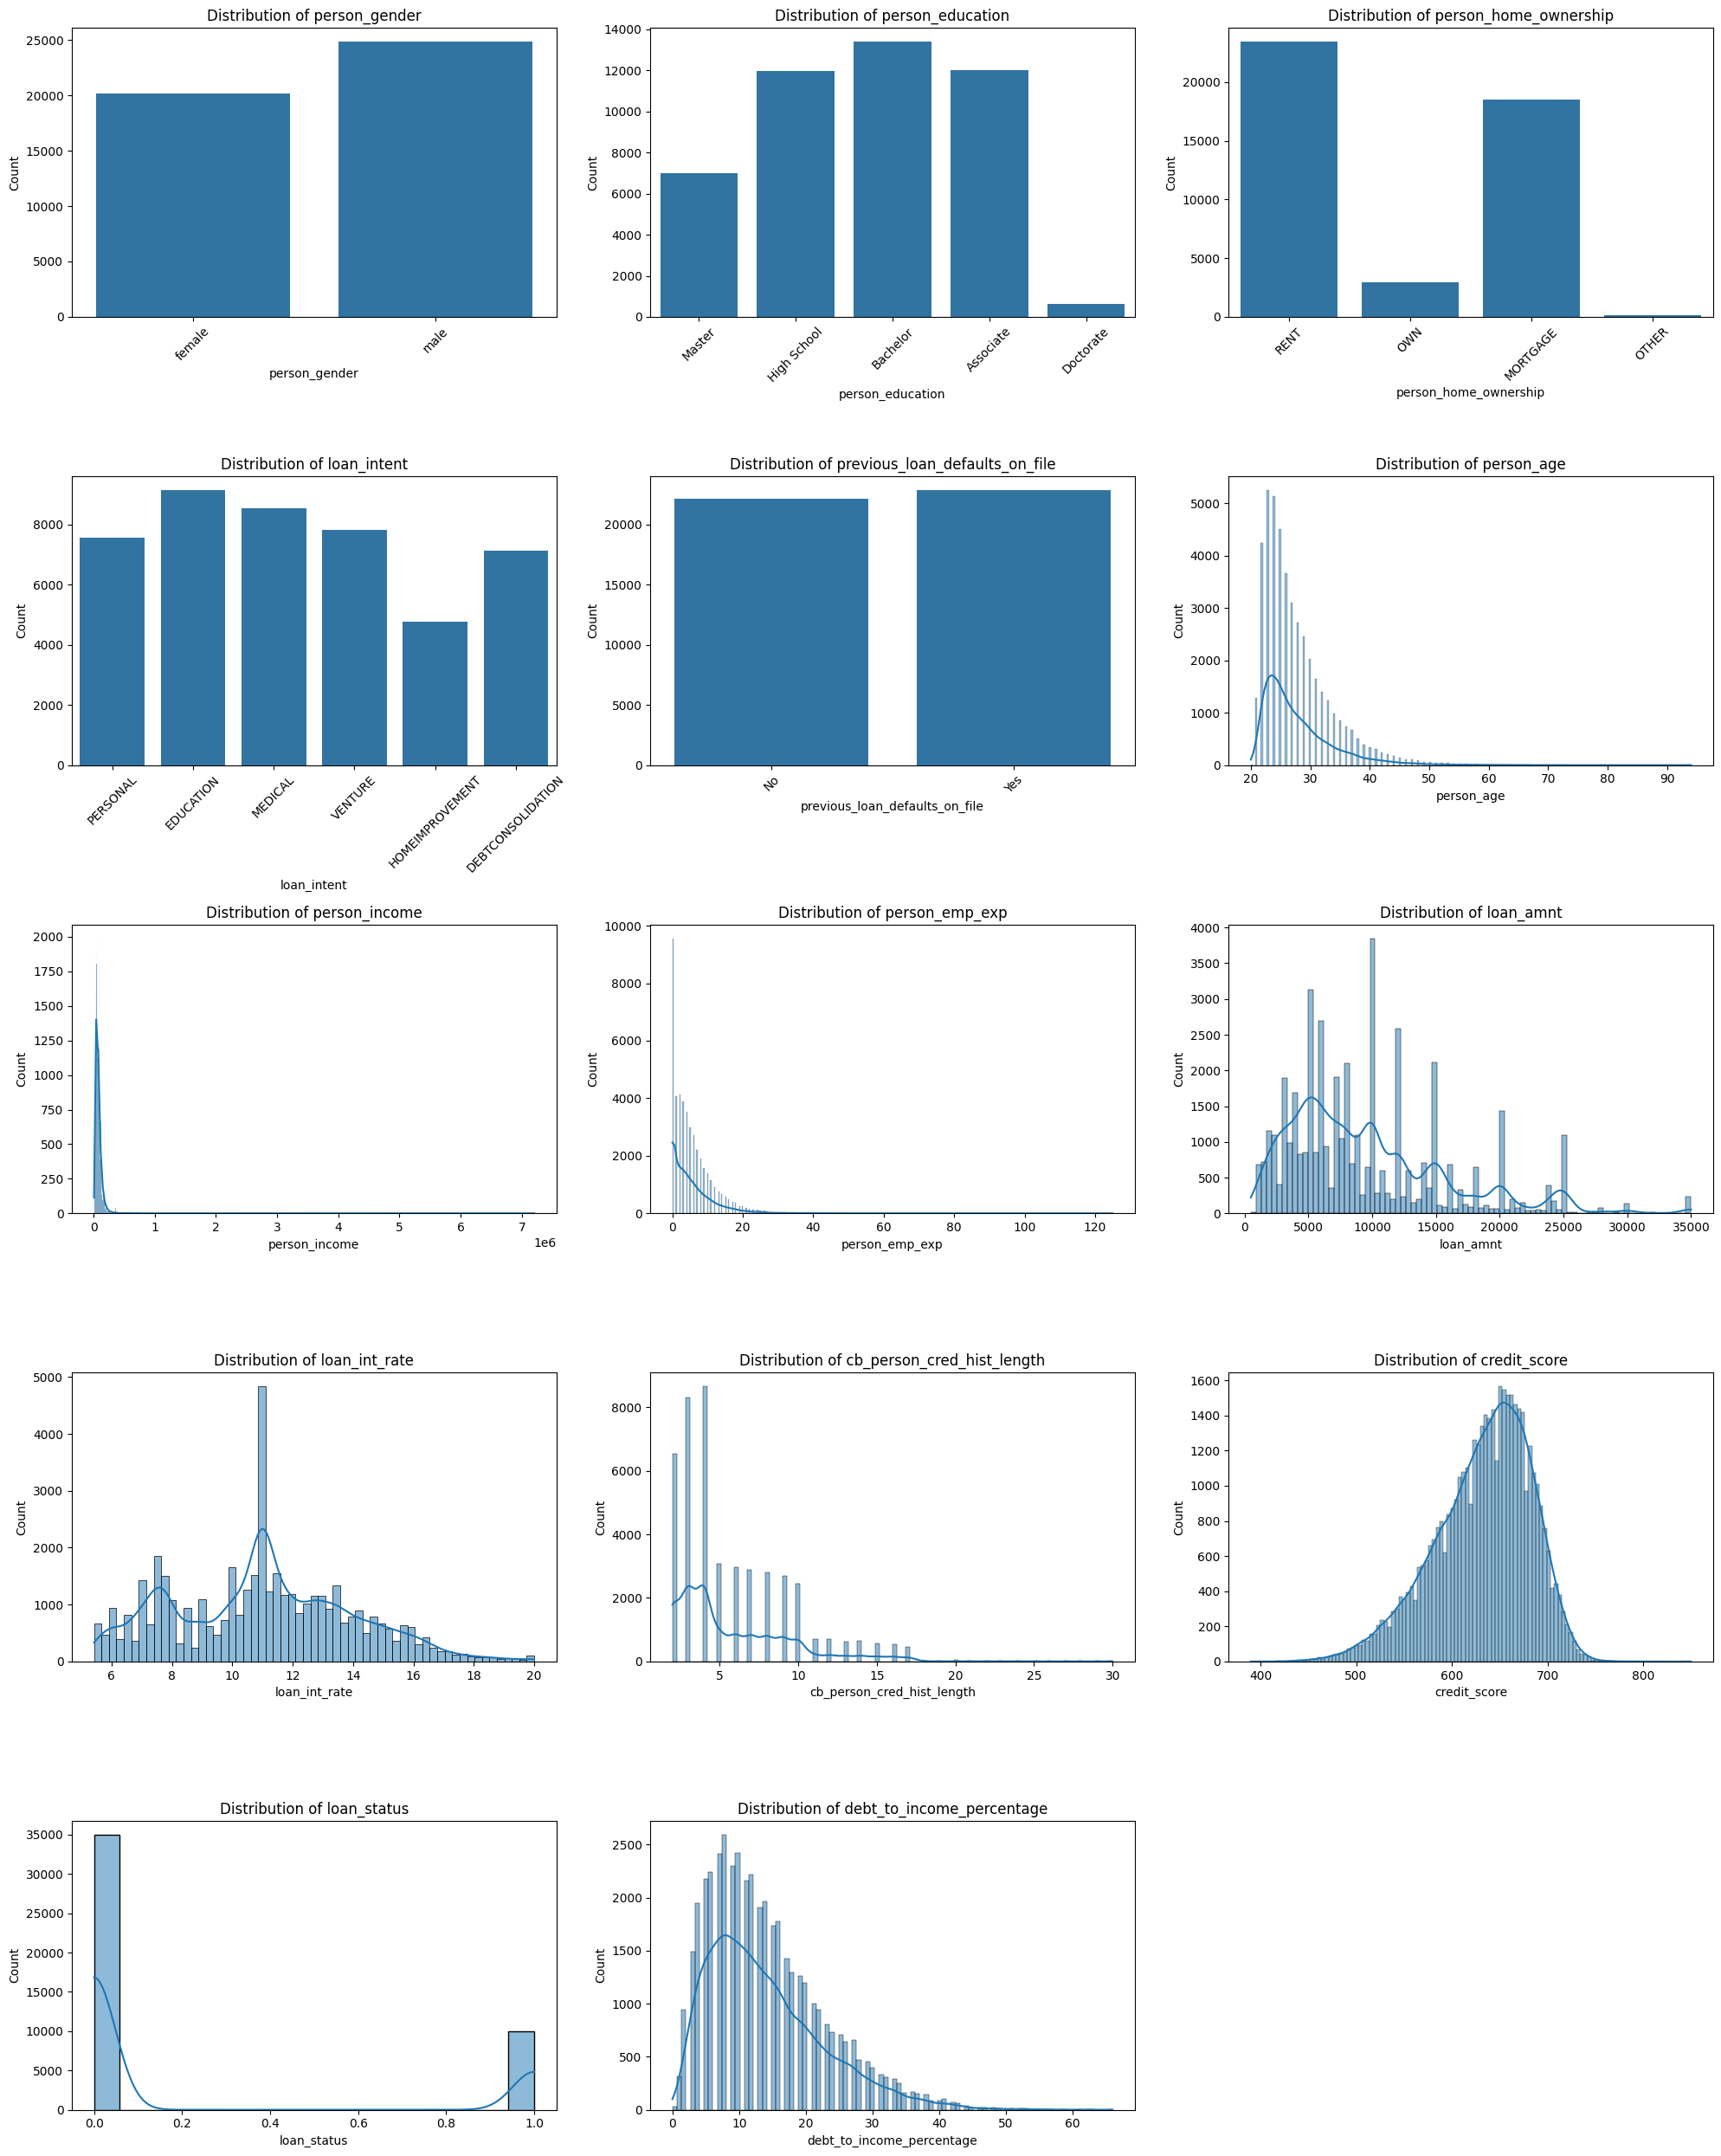

In [12]:
# Plotting the cetegorical and numercial columns
df.plot_all_columns()

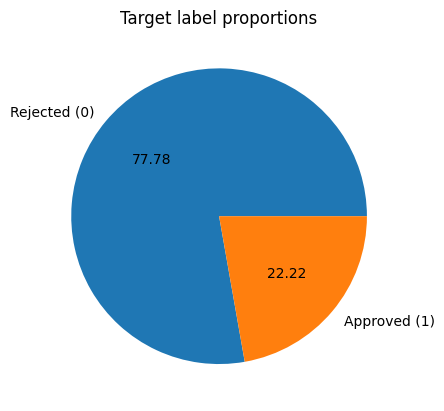

In [13]:
# Looking at the number of values for each column (approved = 1, rejected = 0) for the loan status column 
label_prop = df.data['loan_status'].value_counts()

plt.pie(label_prop.values, labels=['Rejected (0)', 'Approved (1)'], autopct='%.2f')
plt.title('Target label proportions')
plt.show()

We see that we have a higher rate of loans being rejected that approved with 22.22% approval rate compared to 77.78% rejection rate 

In [14]:
# looking at the statistical overview of loan to income ratio
df.data['debt_to_income_percentage'].describe()

count    45000.000000
mean        13.972489
std          8.721231
min          0.000000
25%          7.000000
50%         12.000000
75%         19.000000
max         66.000000
Name: debt_to_income_percentage, dtype: float64

A high loan-to-income ratio indicates that a borrower is allocating a substantial portion of their income towards debt repayment, while a low ratio suggests the opposite. This leads to the following implications:

**Higher Ratio = Higher Risk:**
- Lenders perceive high ratios as indicative of increased default risk.
- Consequences may include higher interest rates or loan rejection.

**Lower Ratio = More Favorable:**
- Demonstrates a better capacity to manage debt payments.
- Typically results in more advantageous loan terms.

Our hypothesis: As the loan-to-income ratio increases, the probability of loan approval decreases. This is because higher ratio

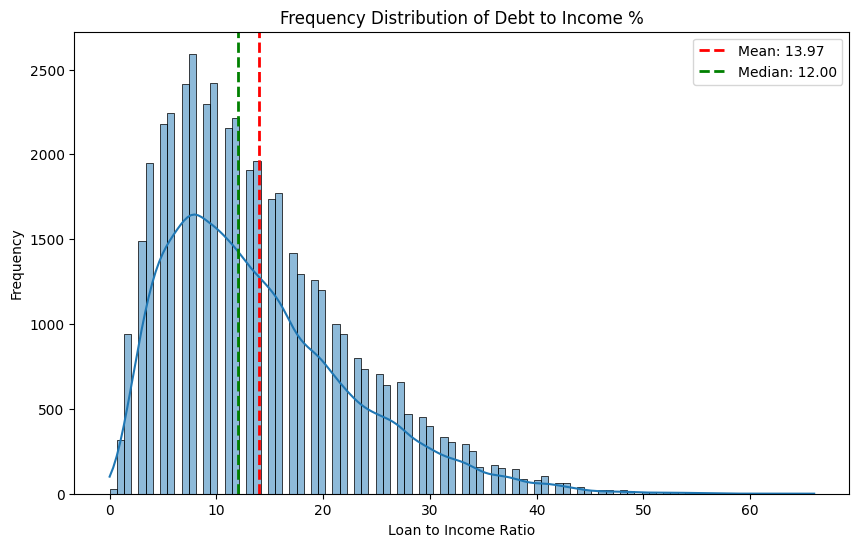

In [15]:
# Plotting a freqency distribution 
plt.figure(figsize=(10, 6))

# Create the histogram
sns.histplot(data=df.data, x='debt_to_income_percentage', stat='count', kde=True)

# Calculate mean and median
mean_value = df.data['debt_to_income_percentage'].mean()
median_value = df.data['debt_to_income_percentage'].median()

# Add vertical lines for mean and median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

plt.title('Frequency Distribution of Debt to Income %')
plt.xlabel('Loan to Income Ratio')
plt.ylabel('Frequency')

# Add legend
plt.legend()

plt.show()

The frequency distribution of the loan-to-income ratio reveals several key insights:

- **Peak Frequency**: The highest frequency occurs at ratios below 10, indicating that a significant portion of the population has relatively low loan-to-income ratios.

- **Right-Skewed Distribution**: The graph exhibits a right-skewed (or positively skewed) distribution. This means that while most individuals have lower loan-to-income ratios, there's a long tail extending towards higher ratios.

- **Concentration of Data**: The majority of the data is clustered towards the left side of the graph, suggesting that most people in the dataset have lower to moderate loan-to-income ratios.

- **Outliers**: There are fewer instances of very high loan-to-income ratios, which appear as a tapering tail on the right side of the distribution.

- **Impact on Central Tendencies**: Due to the skewness, there's a noticeable difference between the mean (13.97) and the median (12.17). The mean is pulled higher by the right tail of the distribution, while the median provides a more representative measure of the central tendency for this skewed data.

- **Interpretation**: This distribution suggests that while most individuals maintain manageable loan-to-income ratios, there's a smaller group with significantly higher ratios, potentially indicating higher financial risk or different borrowing patterns.

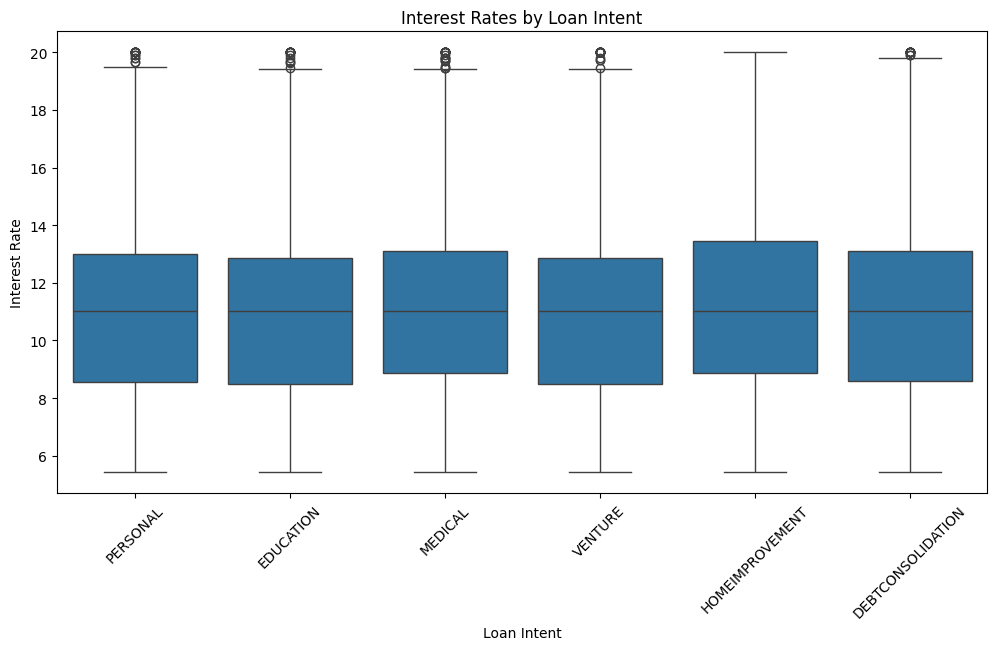

In [16]:
# plot of Interest rate by the loan intent 
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.data, x='loan_intent', y='loan_int_rate')
plt.title('Interest Rates by Loan Intent')
plt.xlabel('Loan Intent')
plt.ylabel('Interest Rate')
plt.xticks(rotation=45)
plt.show()

We can observe that for most loan intents, there isn't a significant variation in interest rates, and they are relatively similar across categories. However, we can see that home improvement loans have a slightly higher mean interest rate compared to the other categories. This subtle difference might suggest that lenders perceive home improvement loans as slightly riskier or that they command a small premium in the market. It's important to note that while this difference exists, it appears to be modest, indicating that loan intent may not be a major factor in determining interest rates for this dataset. 

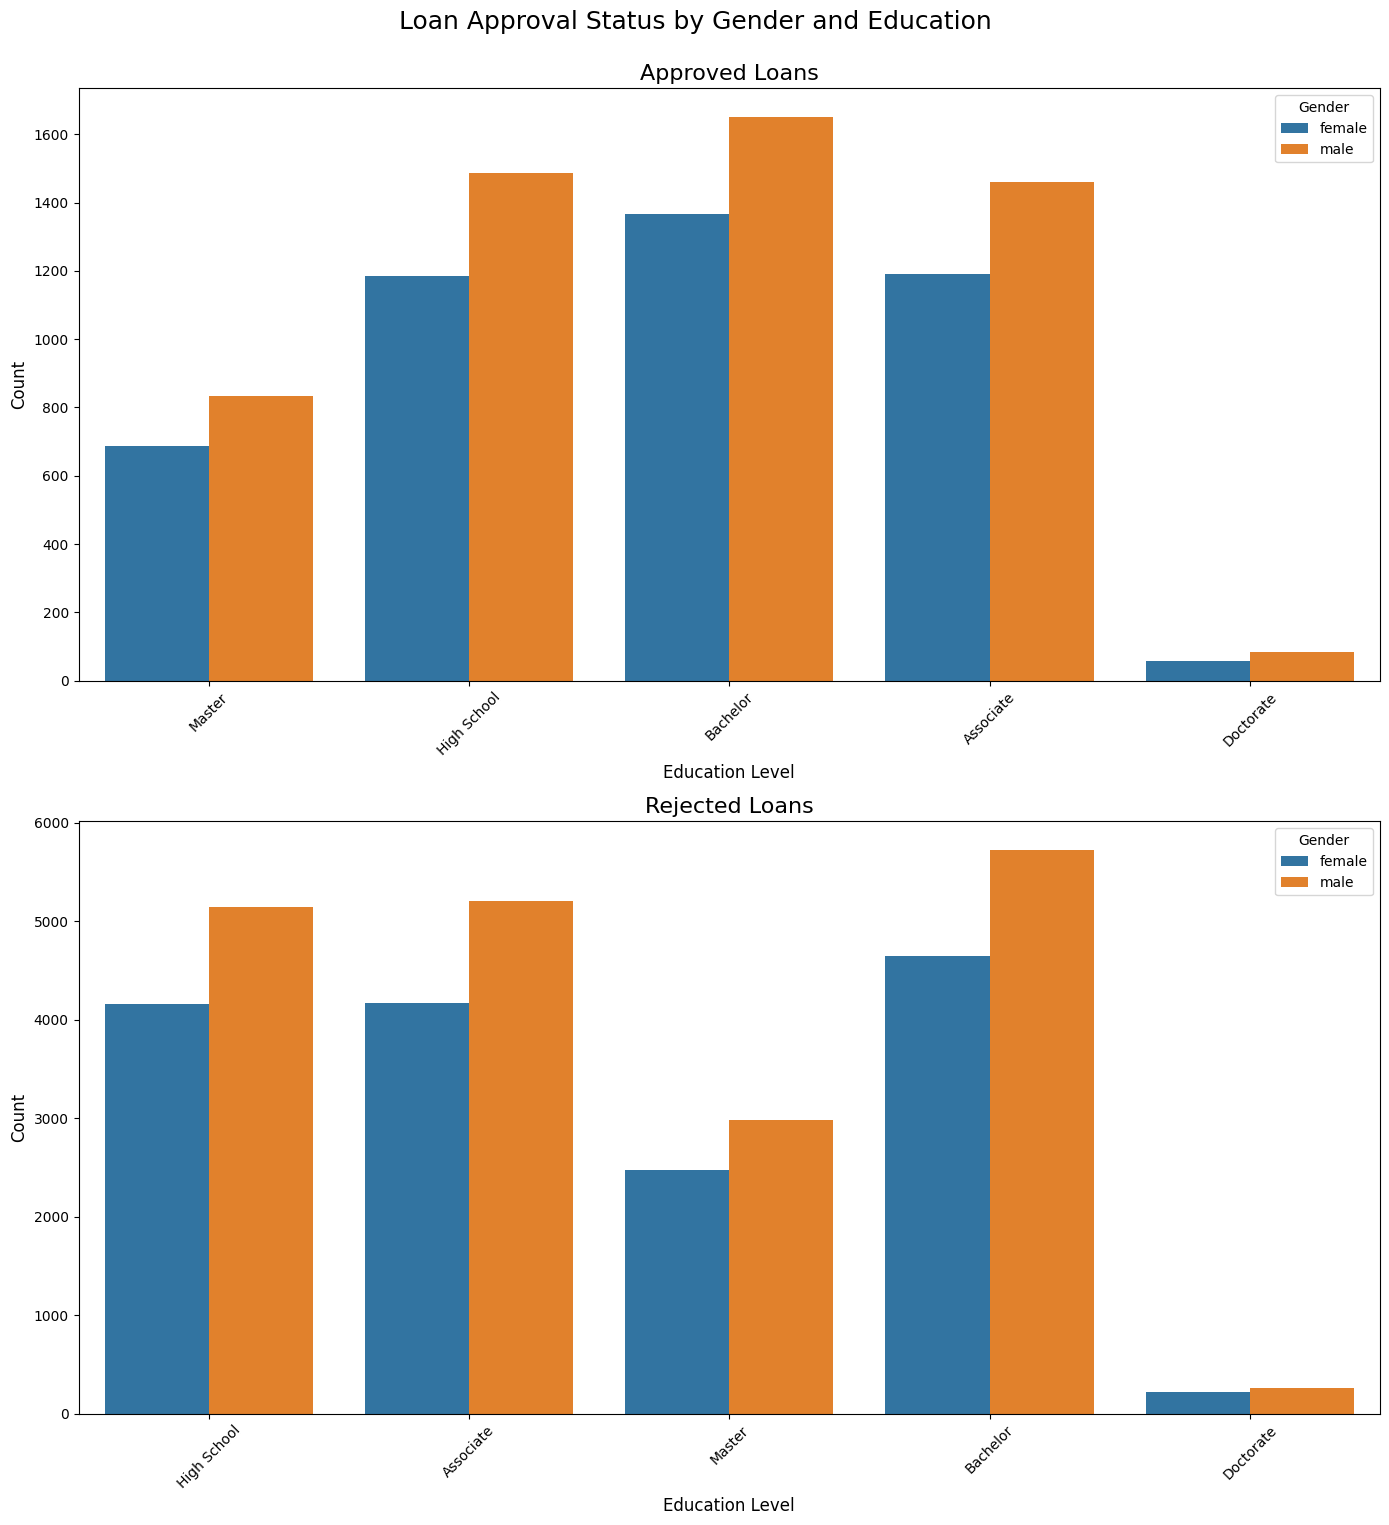

In [17]:
# Set up the figure with two subplots, one on top of the other
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

# Plot for approved loans (loan_status == 1)
sns.countplot(x='person_education', hue='person_gender', 
              data=df.data[df.data['loan_status'] == 1], ax=ax1)
ax1.set_title('Approved Loans', fontsize=16)
ax1.set_xlabel('Education Level', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.legend(title='Gender', loc='upper right')
ax1.tick_params(axis='x', rotation=45)

# Plot for rejected loans (loan_status == 0)
sns.countplot(x='person_education', hue='person_gender', 
              data=df.data[df.data['loan_status'] == 0], ax=ax2)
ax2.set_title('Rejected Loans', fontsize=16)
ax2.set_xlabel('Education Level', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.legend(title='Gender', loc='upper right')
ax2.tick_params(axis='x', rotation=45)

# Add an overall title
fig.suptitle('Loan Approval Status by Gender and Education', fontsize=18, y=0.95)

# Adjust layout and display the plot
plt.tight_layout(rect=[0,0,1,0.95]) 
plt.show()

The graphs provide insights into loan approval and rejection counts based on gender and education level. Below is a detailed analysis:


##### **Graph 1: Approved Loans**
- **Gender:**
  - Loan approvals are consistently higher for males across all education levels compared to females.
  - The disparity between male and female approvals is most noticeable among high school graduates and bachelor's degree holders.
  
- **Education Level:**
  - **Bachelor's degree holders** have the highest loan approval counts, with males leading significantly.
  - **High school graduates** follow closely, showing a similar trend of higher male approvals.
  - **Associate degree holders** have moderate approval counts, with males still dominating.
  - **Master's degree holders** show relatively lower approval counts compared to bachelor's and high school levels, but the gender gap remains consistent.
  - **Doctorate holders** have the lowest approval counts, likely due to fewer applicants in this category.

##### **Graph 2: Rejected Loans**
- **Gender:**
  - Loan rejections are generally higher for males across most education levels.
  - The exception is among master's degree holders, where female rejection counts slightly exceed male rejection counts.
  
- **Education Level:**
  - **High school graduates** and **bachelor's degree holders** experience the highest rejection rates, with males leading in both categories.
  - **Associate degree holders** also show substantial rejection rates, though slightly lower than bachelor's and high school levels.
  - **Master's degree holders** have moderate rejection rates, with the gender gap narrowing slightly compared to other education levels.
  - **Doctorate holders** have minimal rejections, reflecting low application numbers in this category.

##### Key Observations:
1. Males generally dominate both approved and rejected loan counts across all education levels.
2. Bachelor's degree holders are the most active applicants, as they lead both approval and rejection counts.
3. Doctorate holders exhibit significantly lower loan activity overall (both approvals and rejections), indicating fewer applicants in this category.

### Examining Categorical Variables and Encoding Strategies
<a id="encoding"></a>

As we progress towards building our predictive models, it's crucial to address our categorical variables. Many machine learning algorithms, particularly our baseline models, are designed to work with numerical inputs. Therefore, we need to transform our categorical features into a numerical format. Let's consider our approach:

Categorical Feature Analysis

- We have several categorical variables such as **person_gender**, **person_education**, **person_home_ownership**, **loan_intent**, and **previous_loan_defaults_on_file**.
- These variables contain **valuable information** that could significantly influence loan approval decisions.

Encoding Necessity

- **Most machine learning algorithms**, including our baseline models, **require numerical inputs**.
- To leverage the information in our categorical variables, we need to **convert them into a numerical format**.

#### Encoding Strategies

a) Ordinal Encoding

- Suitable for categorical variables with a **clear, logical order**.
- For example, **education levels** (High School, Bachelor's, Master's) could be ordinally encoded.
- This **preserves the inherent order** in the categories.

b) One-Hot Encoding

- Ideal for **nominal categorical variables** without any intrinsic order.
- Variables like **loan_intent** or **person_home_ownership** are good candidates for one-hot encoding.
- This creates **binary columns for each category**, avoiding any implied ordering.

#### Considerations for Encoding

- **Cardinality**: For high-cardinality features (many unique categories), one-hot encoding might lead to a large number of new columns. In such cases, we might consider techniques like **feature hashing** or creating **grouped categories**.
- **Rare Categories**: We should be mindful of categories with very few occurrences, as they might not provide significant predictive power and could lead to overfitting.

#### Implementation Plan

- We'll use **pandas** or **scikit-learn** to implement these encoding techniques.
- For ordinal variables, we'll create a **mapping of categories to numerical values**.
- For nominal variables, we'll apply **one-hot encoding**, being mindful of the dummy variable trap.


In [18]:
# Looking at the value counts for each categorial column so see that we do not have any rare categories 
for col in df.cat_cols: 
    print(f'Value counts for {col}')
    print(df.data[col].value_counts())
    print() 

Value counts for person_gender
person_gender
male      24841
female    20159
Name: count, dtype: int64

Value counts for person_education
person_education
Bachelor       13399
Associate      12028
High School    11972
Master          6980
Doctorate        621
Name: count, dtype: int64

Value counts for person_home_ownership
person_home_ownership
RENT        23443
MORTGAGE    18489
OWN          2951
OTHER         117
Name: count, dtype: int64

Value counts for loan_intent
loan_intent
EDUCATION            9153
MEDICAL              8548
VENTURE              7819
PERSONAL             7552
DEBTCONSOLIDATION    7145
HOMEIMPROVEMENT      4783
Name: count, dtype: int64

Value counts for previous_loan_defaults_on_file
previous_loan_defaults_on_file
Yes    22858
No     22142
Name: count, dtype: int64



Here we see that we do  not have any extremely rare categories within our dataset

In [19]:
# Define the categories in order of seniority
education_order = ['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate']

# Create the OrdinalEncoder with the specified order
enc = OrdinalEncoder(categories=[education_order])

# replace the original column:
df.data['person_education'] = enc.fit_transform(df.data[['person_education']])

In [20]:
print(df.data['person_education'].value_counts())

person_education
2.0    13399
1.0    12028
0.0    11972
3.0     6980
4.0      621
Name: count, dtype: int64


In [21]:
# One-hot encode person_home_ownership and loan_intent, dropping the first column
df.data = pd.get_dummies(df.data, columns=['person_home_ownership', 'loan_intent','person_gender', 
                                           'previous_loan_defaults_on_file'], drop_first=True, dtype=int)

In [22]:
df.head()

,person_age,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,cb_person_cred_hist_length,credit_score,loan_status,debt_to_income_percentage,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,person_gender_male,previous_loan_defaults_on_file_Yes
0,22.0,3.0,71948.0,0,35000.0,16.02,3.0,561,1,49.0,0,0,1,0,0,0,1,0,0,0
1,21.0,0.0,12282.0,0,1000.0,11.14,2.0,504,0,8.0,0,1,0,1,0,0,0,0,0,1
2,25.0,0.0,12438.0,3,5500.0,12.87,3.0,635,1,44.0,0,0,0,0,0,1,0,0,0,0
3,23.0,2.0,79753.0,0,35000.0,15.23,2.0,675,1,44.0,0,0,1,0,0,1,0,0,0,0
4,24.0,3.0,66135.0,1,35000.0,14.27,4.0,586,1,53.0,0,0,1,0,0,1,0,0,1,0


No we see that are our data is numeric while is ideal for out baselone modelling

### Looking into correlation of varibales
<a id="corr"></a>

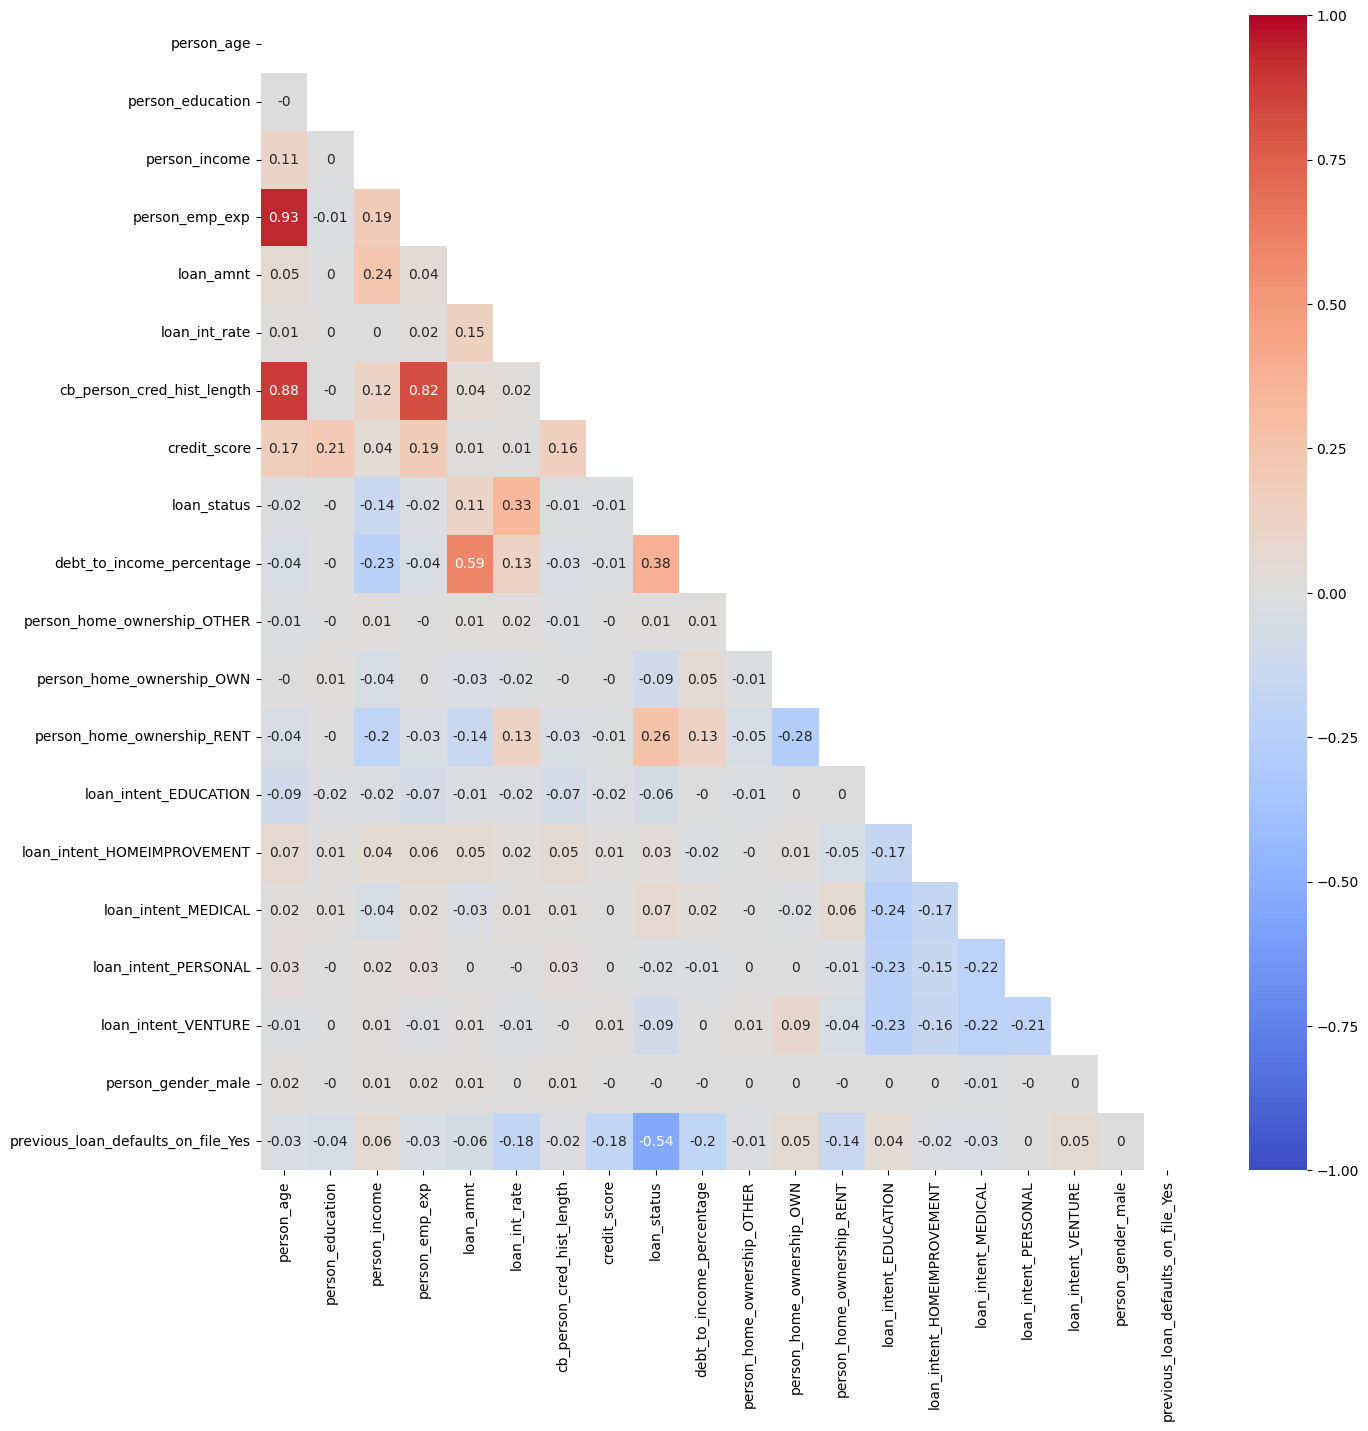

In [23]:
# Selecting only numeric columns (float and integer)
numeric_df = df.data.select_dtypes(include=['float64', 'int64', 'int32'])

# Calculating correlation matrix for numeric columns
correlation_matrix = numeric_df.corr()


# Creating a mask that retains only the upper triangular portion of a correlation matrix,
mask = np.triu(correlation_matrix)

# Plotting heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix.round(2), annot=True, vmax=1, vmin=-1, center=0, cmap='coolwarm', mask=mask)
plt.show()

Thank you for pointing out the need for correction. I'll provide an updated analysis based on the correlation matrix and the correct interpretation of loan status (0 = reject, 1 = approve):

#### Target Variable (loan_status)

- **Moderate Positive Correlation**: Interest rate (0.332), suggesting higher interest rates are associated with a higher likelihood of loan approval.
- **Moderate Positive Correlation**: Debt-to-income percentage (0.385), indicating that as the percentage of income devoted to debt increases, the likelihood of loan approval also increases.
- **Strong Negative Correlation**: Previous loan defaults (-0.543), indicating that having previous defaults is strongly associated with not getting approved for a new loan.

#### Debt-to-Income Percentage

- **Strong Positive Correlation**: Loan amount (0.593), which is expected as larger loans relative to income will increase this percentage.
- **Moderate Negative Correlation**: Income (-0.234), suggesting that higher-income individuals tend to have lower debt-to-income percentages.
- **Moderate Positive Correlation**: Loan status (0.385), indicating that higher debt-to-income percentages are associated with higher approval rates.

#### Other Notable Correlations

- **Age, Employment Experience, and Credit History Length**: Highly correlated with each other (all above 0.82) but have weak correlations with the target variable.
- **Credit Score**: Very weak negative correlation with loan status (-0.008), suggesting minimal impact on approval decisions.
- **Person Income**: Moderate negative correlation with loan status (-0.136), surprisingly suggesting higher income is associated with lower approval rates.

#### Categorical Variables

- **Home Ownership Categories**: Renting is positively correlated (0.255) and owning is negatively correlated (-0.094) with loan approval.
- **Loan Intent Categories**: "VENTURE" loans show the strongest negative correlation (-0.086) with approval.

#### Potential Multicollinearity

- The high correlations between age, employment experience, and credit history length suggest potential multicollinearity, which should be considered in model building.

#### Features with Low Correlation to Target

- **Gender and Education**: Show very weak correlations with loan status, suggesting they might not be strong predictors on their own.

#### Implications for Model Building

This dataset shows some counterintuitive relationships that don't align with typical lending practices. Higher debt-to-income percentages and interest rates are associated with higher approval rates, while higher incomes correlate with lower approval rates. These patterns warrant further investigation into the specific lending practices or potential biases in this dataset.

As we move forward with model building, we'll need to carefully consider these unusual relationships. We should focus on understanding why traditional risk factors appear to have opposite effects in this dataset. Feature engineering, such as creating interaction terms or binning continuous variables, may help capture these complex relationships. We should also consider the possibility of hidden variables or specific lending policies that might explain these patterns.

### Numberical Variable distribution
<a id="standard"></a>

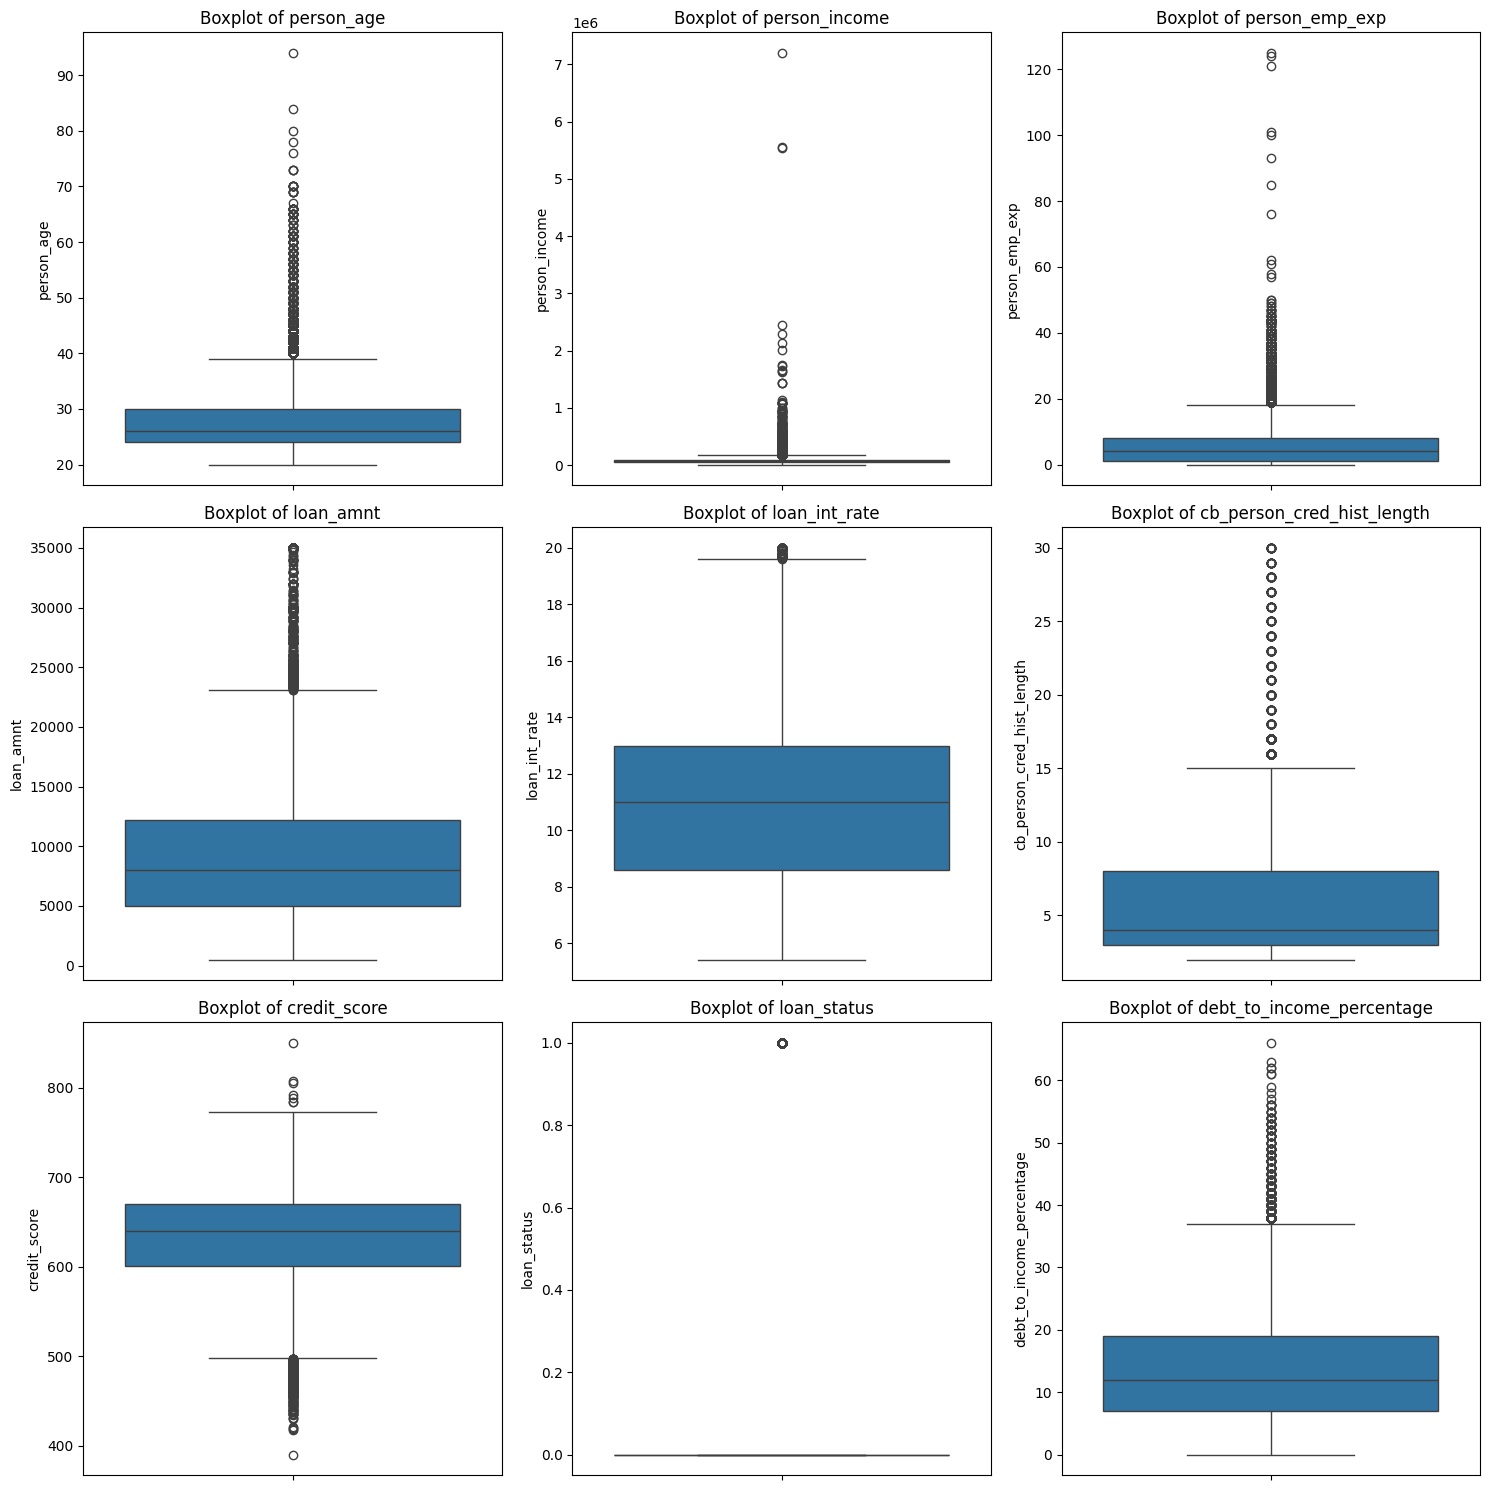

In [24]:
# Looking more closely at the distributions of the numerical columns 

n_cols = 3
n_rows = (len(df.num_cols) + n_cols - 1) // n_cols

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Plot boxplots for each numerical column
for i, col in enumerate(df.num_cols):
    sns.boxplot(data=df.data, y=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

# Remove any unused subplots
for i in range(len(df.num_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

The box plots reveal significant insights about our numerical features:

1. Distribution Patterns:
   - Most columns exhibit non-normal distributions, characterized by visible skewness and the presence of outliers.
   - The loan interest rate stands out as an exception, showing a more symmetrical distribution.

2. Skewness and Outliers:
   - Features such as person_income, loan_amount, and loan_percent_income display notable right-skew, with numerous high-value outliers.
   - The credit_score and person_age variables show a more moderate skew but still contain outliers.

3. Implications for Modeling:
   - The non-normal distributions and presence of outliers in most features suggest that standard linear models might not be optimal without data transformation.
   - Outliers could disproportionately influence our models, potentially leading to biased predictions.

4. Data Preprocessing Requirements:
   - To ensure fair comparison and optimal model performance, we'll need to implement robust standardization techniques.
   - Methods like z-score standardization or min-max scaling will be crucial to bring all features to a comparable scale.
   - For heavily skewed variables, we might consider logarithmic or other power transformations to mitigate the impact of extreme values.

By addressing these distribution issues through appropriate preprocessing and feature engineering, we can enhance the reliability and performance of our predictive models, ensuring a more accurate assessment of loan approval probabilities.


Now that we have all the cleaning and preprocessing done. Let's start building the mode! 

## Model Development
<a id="model"></a>

### Logistic Regression - Baseline Model
<a id="base"></a>
[Back to the Top](#TOC)

Let's start by building our baseline logistic regression model, as this is a classification problem. This will serve as a benchmark for performance and help us understand the initial relationships between our features and loan approval status. We are also droping the column person_emp_exp from the dataset as this columns has a have colinearity with persons age, this makes sense and generaly people who are old would have more experience in terms of years worked. 

In [29]:
# spliting data into target and feature
y = df.data[['loan_status']]
X = df.data.drop(columns=['loan_status', 'person_emp_exp'])

In [30]:
X.head()

,person_age,person_education,person_income,loan_amnt,loan_int_rate,cb_person_cred_hist_length,credit_score,debt_to_income_percentage,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,person_gender_male,previous_loan_defaults_on_file_Yes
0,22.0,3.0,71948.0,35000.0,16.02,3.0,561,49.0,0,0,1,0,0,0,1,0,0,0
1,21.0,0.0,12282.0,1000.0,11.14,2.0,504,8.0,0,1,0,1,0,0,0,0,0,1
2,25.0,0.0,12438.0,5500.0,12.87,3.0,635,44.0,0,0,0,0,0,1,0,0,0,0
3,23.0,2.0,79753.0,35000.0,15.23,2.0,675,44.0,0,0,1,0,0,1,0,0,0,0
4,24.0,3.0,66135.0,35000.0,14.27,4.0,586,53.0,0,0,1,0,0,1,0,0,1,0


In [31]:
# First let's split our data into training and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
print(f'X_train shape = {X_train.shape}, y_train shape = {y_train.shape}')
print(f'X_test shape = {X_test.shape}, y_test shape = {y_test.shape}')

X_train shape = (36000, 18), y_train shape = (36000, 1)
X_test shape = (9000, 18), y_test shape = (9000, 1)


The dataset for our loan approval classification project presents a significant class imbalance challenge. Specifically, only 22.22% of the loans are approved (class 1), while 77.78% are rejected (class 0). This stark imbalance poses a critical issue for traditional classification models, which tend to bias towards the majority class. Consequently, without intervention, our model would likely excel at predicting loan rejections but struggle to accurately identify approved loans, which are often the cases of greatest interest in real-world applications.

To mitigate this imbalance and improve our model's performance, we will employ SMOTE (Synthetic Minority Over-sampling Technique). SMOTE is an advanced oversampling method that creates synthetic examples of the minority class (approved loans) by interpolating between existing minority samples. This approach offers several advantages over simple random oversampling:

1. It expands the feature space of the minority class, making the samples more diverse and representative.
2. It reduces the risk of overfitting that can occur with simple duplication of minority samples.
3. It allows the model to learn more robust decision boundaries between the two classes.

By applying SMOTE to our training data, we aim to achieve a more balanced dataset where the model can learn equally from both approved and rejected loan cases. This balanced learning should lead to a model that can more accurately predict both loan approvals and rejections, thereby providing more reliable and actionable insights for loan approval decisions.

It's important to note that we will apply SMOTE only to the training data, preserving the original distribution in our test set. This approach ensures that our model's performance is evaluated on a dataset that reflects the real-world class distribution, maintaining the integrity of our assessment while benefiting from improved learning on balanced training data.

In [32]:
# instantiate SMOTE sampler, fit it to the training data, then resample the data

smote = SMOTE(random_state=1)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [35]:
# Check if y_train is a DataFrame or Series
if isinstance(y_train, pd.DataFrame):
    # If y_train is a DataFrame, convert it to a Series first
    y_train_series = y_train.squeeze()  # Converts a single-column DataFrame to a Series
else:
    # Otherwise, directly convert it to a pandas Series
    y_train_series = pd.Series(y_train)

# Display the class distribution
print('\nResampled class distribution:')
display(y_train_series.value_counts().sort_index())


Resampled class distribution:


loan_status
0    28016
1    28016
Name: count, dtype: int64

In [36]:
# Scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
# initializing the baseline model 
logistic_model = LogisticRegression(max_iter=1000, random_state=40)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=40)

In [38]:
# seeing the score for the train set
logistic_model.score(X_train, y_train)

0.9086057966876071

In [39]:
# Prediting on the x_test 
y_pred = logistic_model.predict(X_test)
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

In [40]:
pred_probs = logistic_model.predict_proba(X_test)
pred_probs[:10, 1]

array([7.28710096e-05, 7.12371359e-01, 7.22827852e-02, 8.90404260e-01,
       9.36428675e-01, 4.21972180e-05, 7.30642633e-07, 7.64579712e-01,
       1.54620521e-05, 9.14466100e-07])

In [41]:
# seeing the score for the test set
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8775555555555555

In [42]:
# Generate the classification report as a dictionary
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the dictionary to a DataFrame and transpose it
df_classification_report = pd.DataFrame(report).transpose()

# Sort the DataFrame by f1-score in descending order
df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)

# Display the DataFrame
print(df_classification_report)

              precision    recall  f1-score      support
0              0.953578  0.885309  0.918176  6984.000000
weighted avg   0.892663  0.877556  0.882037  9000.000000
accuracy       0.877556  0.877556  0.877556     0.877556
macro avg      0.817608  0.868002  0.837508  9000.000000
1              0.681638  0.850694  0.756840  2016.000000


In [48]:
# getting the score for ROC AUC curve
precision_train, recall_train, _ = precision_recall_curve(y_train, logistic_model.predict_proba(X_train)[:, 1])

precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba)
# Compute PR AUC
print('PR-AUC Training set: ', auc(recall_train, precision_train))
print('PR-AUC Test set: ', auc(recall_test, precision_test))

PR-AUC Training set:  0.9687570756660028
PR-AUC Test set:  0.8281085245105813


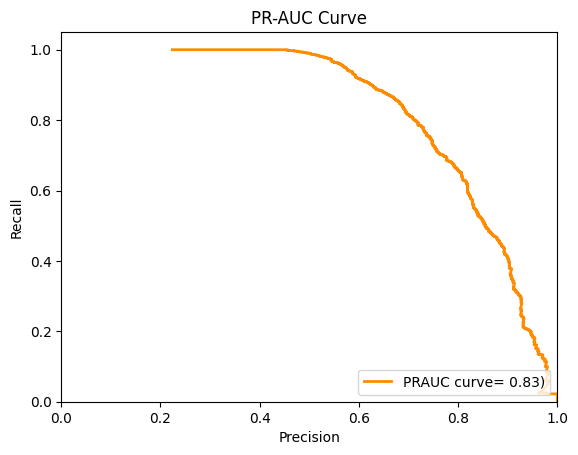

In [49]:
# Calculate the PR curve components
precision_test, recall_test, thresholds = precision_recall_curve(y_test, y_pred_proba)
prauc = auc(recall_test, precision_test)

# Plot the ROC curve:
plt.figure()
plt.plot(precision_test, recall_test, color='darkorange', lw=2, label=f'PRAUC curve= {prauc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('PR-AUC Curve')
plt.legend(loc="lower right")
plt.show()

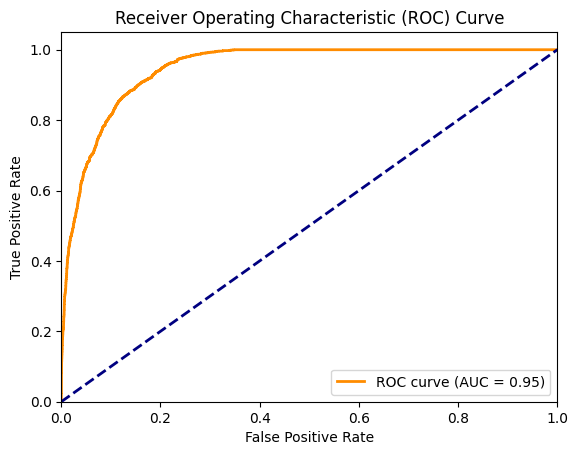

In [50]:
# Calculate the ROC curve components
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [51]:
# Create the DataFrame
coeffs_df = pd.DataFrame({
    "Feature": X.columns,  # Assuming X is your feature matrix
    "Coefficient": logistic_model.coef_[0],  # Use [0] as coef_ is a 2D array
    "Odds_Ratio": np.exp(logistic_model.coef_[0])
})

# Sort by absolute value of coefficients (optional)
coeffs_df['Abs_Coefficient'] = abs(coeffs_df['Coefficient'])
coeffs_df = coeffs_df.sort_values('Abs_Coefficient', ascending=False).drop('Abs_Coefficient', axis=1)

# Print the DataFrame without index
print(coeffs_df.to_string(index=False))

                           Feature  Coefficient  Odds_Ratio
previous_loan_defaults_on_file_Yes    -4.911261    0.007363
         debt_to_income_percentage     1.723968    5.606734
                     loan_int_rate     1.148419    3.153204
               loan_intent_VENTURE    -0.971659    0.378455
             loan_intent_EDUCATION    -0.892625    0.409579
                         loan_amnt    -0.823307    0.438978
              loan_intent_PERSONAL    -0.775205    0.460609
               loan_intent_MEDICAL    -0.649231    0.522447
         person_home_ownership_OWN    -0.465636    0.627736
                      credit_score    -0.464035    0.628741
       loan_intent_HOMEIMPROVEMENT    -0.460083    0.631231
                person_gender_male    -0.236378    0.789483
        person_home_ownership_RENT     0.109233    1.115422
                     person_income     0.075884    1.078837
                        person_age     0.070572    1.073121
        cb_person_cred_hist_length    -0

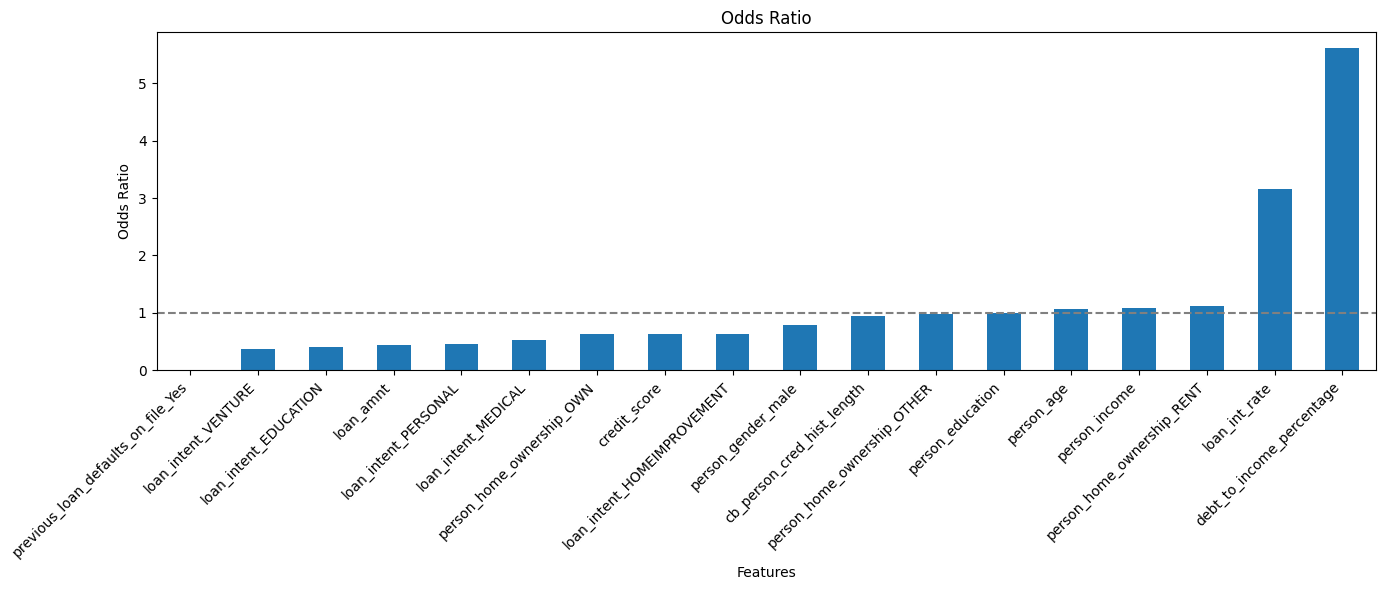

In [52]:
# Sort the DataFrame by odds ratio
sorted_df = coeffs_df.sort_values("Odds_Ratio")

# Create the plot
plt.figure(figsize=(14, 6))  # Increase figure size
sorted_df["Odds_Ratio"].plot(kind="bar")

# Add horizontal line at y=1
plt.axhline(y=1, c="gray", linestyle="--")

# Set title and labels
plt.title("Odds Ratio")
plt.ylabel("Odds Ratio")
plt.xlabel("Features")

# Rotate x-axis labels and set their position
plt.xticks(range(len(sorted_df)), sorted_df["Feature"], rotation=45, ha='right')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Logistic Regression Model Interpretation:

1. Previous Loan Defaults: Having previous loan defaults on file (Yes) is the strongest negative predictor (coefficient -4.911261, odds ratio 0.007363). This dramatically decreases the odds of loan approval.

2. Debt-to-Income Percentage: This is the strongest positive predictor (coefficient 1.723968, odds ratio 5.606734). Higher debt-to-income ratios are associated with increased odds of loan approval, which is counterintuitive and warrants further investigation.

3. Loan Interest Rate: Higher interest rates are associated with increased odds of loan approval (coefficient 1.148419, odds ratio 3.153204).

4. Loan Amount: Larger loan amounts decrease the odds of approval (coefficient -0.823307, odds ratio 0.438978).

5. Loan Intent: Compared to the baseline (DEBTCONSOLIDATION), all listed intents decrease approval odds. VENTURE has the strongest negative impact (coefficient -0.971659, odds ratio 0.378455), followed by EDUCATION and PERSONAL.

6. Credit Score: Surprisingly, higher credit scores slightly decrease approval odds (coefficient -0.464035, odds ratio 0.628741). This counterintuitive result needs further examination.

7. Home Ownership: Owning a home decreases approval odds compared to the baseline (MORTGAGE), while renting slightly increases odds (coefficient for RENT 0.109233, odds ratio 1.115422).

8. Gender: Being male slightly decreases approval odds (coefficient -0.236378, odds ratio 0.789483).

9. Age and Income: Both have slight positive impacts on approval odds, with income (coefficient 0.075884, odds ratio 1.078837) having a stronger effect than age (coefficient 0.070572, odds ratio 1.073121).

10. Credit History Length: Has a very small negative impact (coefficient -0.046843, odds ratio 0.954237).

The model suggests that previous defaults, debt-to-income ratio, and interest rates remain the most influential factors. Some counterintuitive results (like credit score impact) persist, which might indicate multicollinearity or need for model refinement.

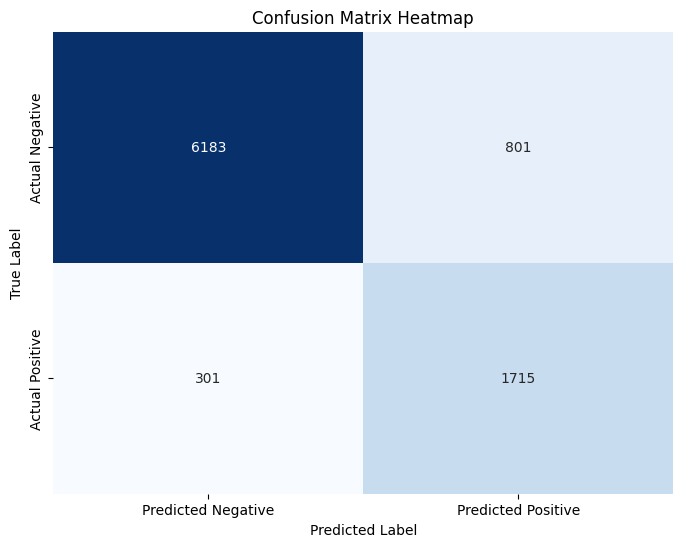

In [54]:
# Creating a confusion matrix 
conf_matrix =confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

#### Comprehensive Metrics Breakdown

1. **Accuracy: 87.76%**
   - The model correctly classifies 87.76% of all instances (7,898 out of 9,000).
   - This is a good overall performance, but it's important to consider other metrics for a balanced evaluation.

2. **Precision: 68.17%**
   - Out of 2,516 positive predictions, 1,715 are correct.
   - This precision indicates that about two-thirds of the model's positive predictions are accurate.

3. **Recall (Sensitivity): 85.07%**
   - The model correctly identifies 85.07% of all actual positive instances (1,715 out of 2,016).
   - This high recall suggests the model is effective at catching most positive cases.

4. **Specificity: 88.53%**
   - The model correctly identifies 88.53% of all actual negative instances (6,183 out of 6,984).
   - This specificity shows the model is good at distinguishing negative cases.

5. **F1 Score: 0.7570**
   - This F1 score demonstrates a balance between precision and recall, though there is room for improvement.

6. **False Positive Rate: 11.47%**
   - This rate indicates the proportion of negative instances misclassified as positive.

7. **False Negative Rate: 14.93%**
   - This rate shows the model misses about 15% of actual positive cases.

#### Class Distribution Analysis
- Negative class: 6,984 instances (77.6% of total)
- Positive class: 2,016 instances (22.4% of total)
- The dataset shows a class imbalance, with the negative class being more prevalent.

#### Error Analysis
- False Positives (801): These could lead to unnecessary actions or costs in real-world applications.
- False Negatives (301): These missed positive cases could be critical depending on the domain.

#### Implications for the Project

1. **Good Overall Performance**: The model demonstrates good accuracy and a reasonable balance between precision and recall.

2. **Effective at Capturing Positive Cases**: The high recall ensures that most positive instances are correctly identified.

3. **Strong Negative Case Identification**: The model is effective at distinguishing negative cases.

4. **Consideration of Class Imbalance**: The model performs on an imbalanced dataset, which affects its performance metrics.

5. **Application-Specific Evaluation Needed**: The importance of false positives versus false negatives should be carefully considered.

### Logistic Regression Model with PCA 

Let's now use PCA to reduce dimentionality and improve out model predictions

In [56]:
# We want to keep 90% of the variance
my_PCA = PCA()
my_PCA = PCA(n_components = 0.90)
my_PCA.fit(X_train)

# Transform train and test
X_train_PCA = my_PCA.transform(X_train)
X_test_PCA = my_PCA.transform(X_test)
print(f'PCA Transformed: {X_train_PCA.shape}')

PCA Transformed: (56032, 14)


In [57]:
# initializing the baseline model 
logistic_model_PCA = LogisticRegression(max_iter=1000, random_state=40)
logistic_model_PCA.fit(X_train_PCA, y_train)

LogisticRegression(max_iter=1000, random_state=40)

In [58]:
# seeing the score for the train set
logistic_model_PCA.score(X_train_PCA, y_train)

0.9038942033123929

In [59]:
# Prediting on the x_test 
y_pred_PCA = logistic_model_PCA.predict(X_test_PCA)
y_pred_proba = logistic_model_PCA.predict_proba(X_test_PCA)[:, 1]

In [60]:
# seeing the score for the test set
accuracy_score_PCA = accuracy_score(y_test, y_pred_PCA)
accuracy_score_PCA

0.8654444444444445

In [61]:
print(f'The accruray score for the model with all the features was {accuracy}')
print(f'The accruray score with Princle component analysis model was {accuracy_score_PCA}')

The accruray score for the model with all the features was 0.8775555555555555
The accruray score with Princle component analysis model was 0.8654444444444445


In [62]:
my_PCA.explained_variance_ratio_

array([0.11296888, 0.10842923, 0.08042262, 0.06651845, 0.06532507,
       0.06478878, 0.06336846, 0.0613849 , 0.05887107, 0.05705114,
       0.05533514, 0.05203296, 0.04397728, 0.03859997])

In [63]:
# Pull out the coefficients
coefs = logistic_model_PCA.coef_

pd.DataFrame(coefs.T, index=['PC1','PC2', 'PC3', 'PC4','PC5','PC6','PC7', 'PC8', 
                             'PC9','PC10', 'PC11', 'PC12', 'PC13', 'PC14'], columns=['coefficient_vals'])

,coefficient_vals
PC1,-1.173746
PC2,2.560507
PC3,-0.844766
PC4,0.245402
PC5,-0.337134
PC6,-0.231123
PC7,0.167272
PC8,0.772364
PC9,0.029590
PC10,-0.914392


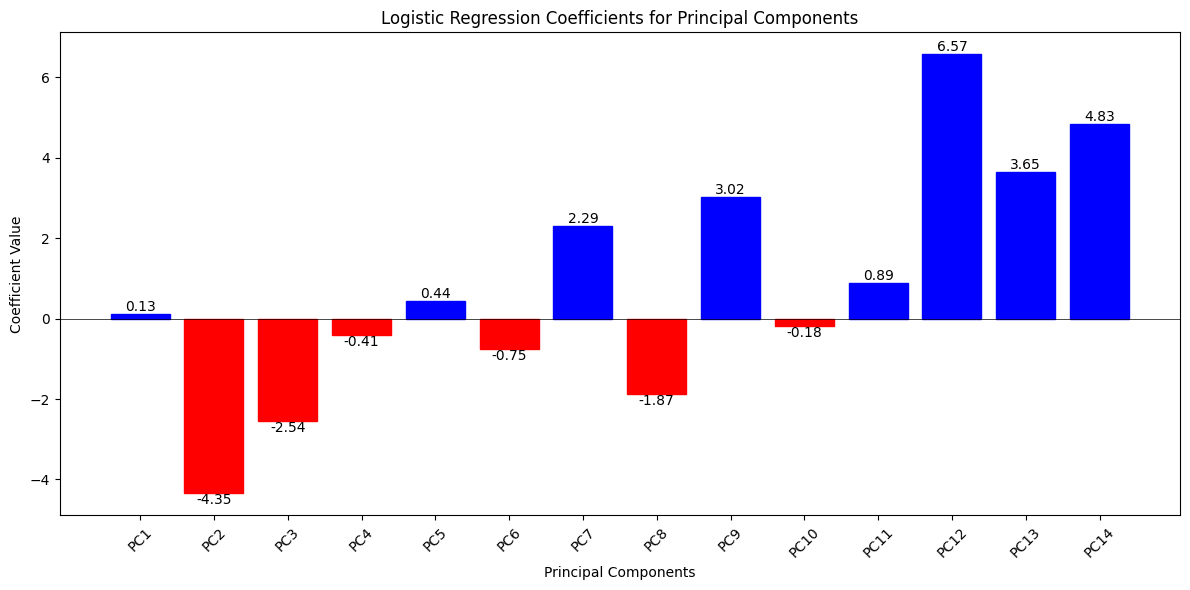

In [64]:
# Create a DataFrame with the PCA coefficients
pca_coeffs = pd.DataFrame({
    'PC': [f'PC{i}' for i in range(1, 15)],
    'coefficient_vals': [0.125958, -4.349121, -2.540124, -0.413482, 0.436927, -0.750360, 
                         2.292099, -1.873417, 3.022777, -0.181354, 0.891397, 6.571618, 3.645172, 4.834023]
})

# Create the plot
plt.figure(figsize=(12, 6))

# Create a bar plot
bars = plt.bar(pca_coeffs['PC'], pca_coeffs['coefficient_vals'])

# Color the bars based on their value
for bar in bars:
    if bar.get_height() < 0:
        bar.set_color('red')
    else:
        bar.set_color('blue')

plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)

plt.title('Logistic Regression Coefficients for Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)

# Add value labels on the bars
for i, v in enumerate(pca_coeffs['coefficient_vals']):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom' if v > 0 else 'top')

plt.tight_layout()
plt.show()


The coefficients represent the relative contribution of each Principal Component (PC) to the model's predictions:

- Components with larger absolute values, such as PC2, PC12, PC14, and PC1, are the most influential in determining outcomes.

- Positive coefficients (e.g., PC2, PC12, and PC8) suggest these PCs are associated with an increased likelihood of positive predictions.

- Negative coefficients (e.g., PC14, PC1, and PC3) indicate these PCs contribute to negative predictions.

- Components with smaller absolute values (e.g., PC9 and PC11) have minimal impact on the model's predictions.

This analysis highlights which Principal Components drive model behavior, offering insights into how dimensionality reduction via PCA contributes to prediction accuracy. Further investigation into the original features contributing to these PCs may provide actionable insights for improving model performance or understanding underlying patterns in the data.

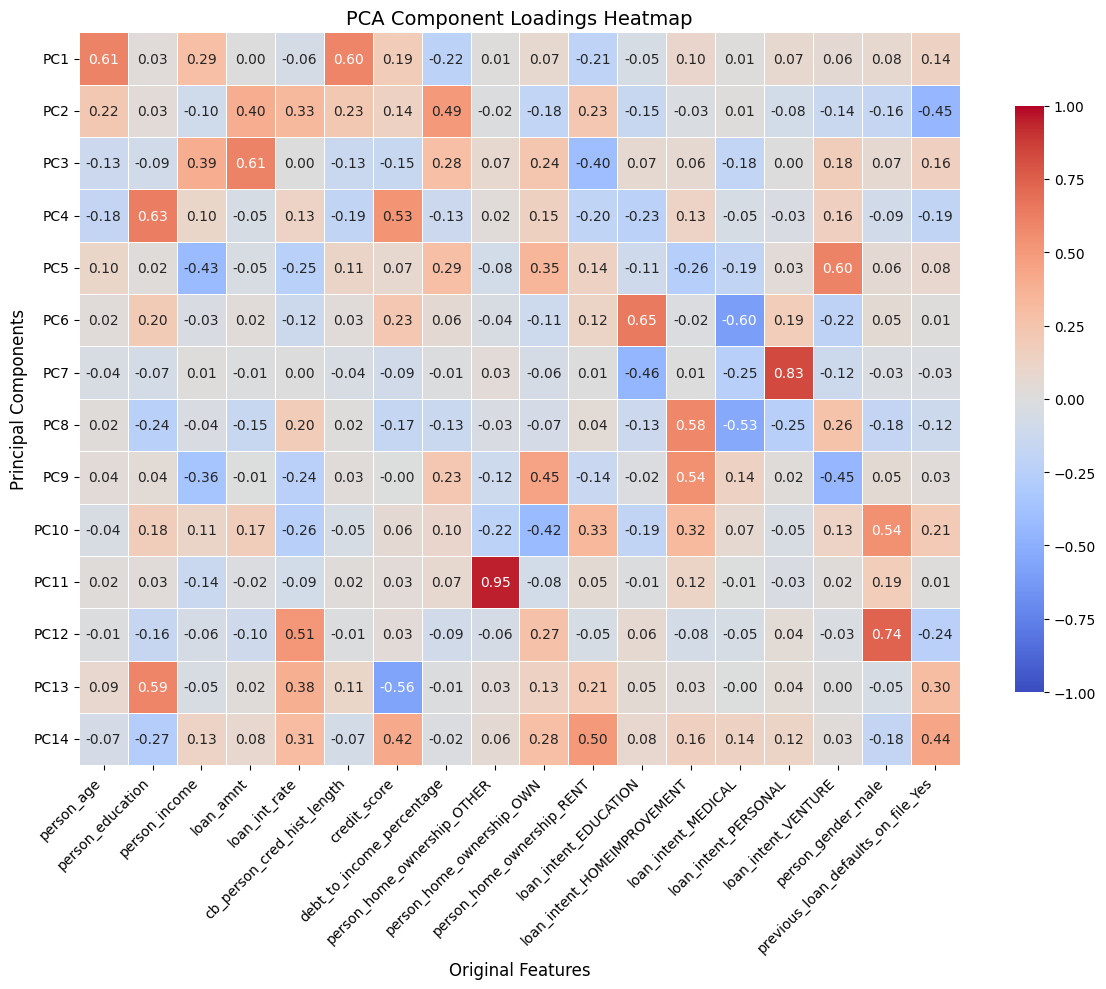

In [65]:
plt.figure(figsize=(12, 10)) 

# Create the heatmap
ax = sns.heatmap(
    my_PCA.components_,
    cmap='coolwarm',
    yticklabels=["PC" + str(x) for x in range(1, my_PCA.n_components_ + 1)],
    xticklabels=list(X.columns),
    linewidths=0.5,  # Reduce line thickness for a cleaner look
    annot=True,
    fmt=".2f",  # Format annotations to two decimal places
    vmin=-1,
    vmax=1,
    cbar_kws={"orientation": "vertical", "shrink": 0.8}  # Shrink color bar for better proportions
)

# Adjust tick label rotation and font size for clarity
plt.yticks(rotation=0, fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add labels and title for better context
plt.xlabel("Original Features", fontsize=12)
plt.ylabel("Principal Components", fontsize=12)
plt.title("PCA Component Loadings Heatmap", fontsize=14)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

This heatmap visualizes how each original feature contributes to the construction of the principal components (PCs). The color intensity indicates the strength of the relationship, with red representing a positive loading and blue representing a negative loading.

#### **Key Observations:**

*   **PC1**: Heavily influenced positively by `credit_score` (0.60) and negatively by `person_age` (-0.61), suggesting it captures a dimension contrasting older individuals with potentially lower credit scores.
*   **PC2**: Significantly and positively loaded on `person_education` (0.63) and `debt_to_income_percentage` (0.53), indicating a component related to educational attainment and financial burden.
*   **PC3**: Dominated by a strong positive loading on `loan_amnt` (0.61), making it primarily represent the loan amount's variance.
*   **PC4**: High positive loading from `loan_int_rate` (0.40), suggesting a component related to the loan's interest rate and perhaps risk.
*   **PC5**: This component has negative loading from `person_income` (-0.43).
*   **PC6**: Notably loaded on the `loan_intent_VENTURE` (0.60) indicating it related to a venture loan and and `loan_intent_MEDICAL` is negative (-0.60).
*   **PC7**: Heavily impacted by `person_gender_male` (0.83).
*   **PC8**: Influenced by  `loan_intent_PERSONAL` (-0.53) but possitively impacted by `loan_intent_EDUCATION` (0.58).
*   **PC9**: Heavily negatively impacted by `person_income` (-0.36) and possitively impacted by  `loan_intent_HOMEIMPROVEMENT` (0.54).
*   **PC10**: Negatively impacts by  `person_home_ownership_RENT` (-0.42) and possitively impacted by `previous_loan_defaults_on_file_Yes` (0.54).
*   **PC11**: High positive loading from `person_home_ownership_OTHER` (0.95), suggesting it isolate people who did not have the other options.
*   **PC12**: High positive loading from `previous_loan_defaults_on_file_Yes` (0.74), suggests this strongly represents past default.
*   **PC13**: is possitively loaded on `person_education` (0.59) and is negatively loaded on  `debt_to_income_percentage` (-0.56) .
*   **PC14**: Positive impacted by  `debt_to_income_percentage` (0.42) and `previous_loan_defaults_on_file_Yes` (0.44).

By analyzing these relationships, we can gain insights into how the original features are compressed and represented by each principal component, which can aid in feature selection, model interpretation, and understanding the underlying structure of the data.

## K Nearest Neigbors 
<a id="KNN"></a>
[Back to the Top](#TOC)

k-Nearest Neighbors (KNN) is a simple, easy-to-implement supervised machine learning algorithm used for classification and regression. It classifies new data points based on the majority class among its 'k' nearest neighbors in the feature space. 

In [66]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [67]:
# looking at the accuracy for KNN
y_pred_knn = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_knn)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 87.20%


In [68]:
# Generate the classification report as a dictionary
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the dictionary to a DataFrame and transpose it
df_classification_report = pd.DataFrame(report).transpose()

# Sort the DataFrame by f1-score in descending order
df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)

# Display the DataFrame
print(df_classification_report)

              precision    recall  f1-score      support
0              0.953578  0.885309  0.918176  6984.000000
weighted avg   0.892663  0.877556  0.882037  9000.000000
accuracy       0.877556  0.877556  0.877556     0.877556
macro avg      0.817608  0.868002  0.837508  9000.000000
1              0.681638  0.850694  0.756840  2016.000000


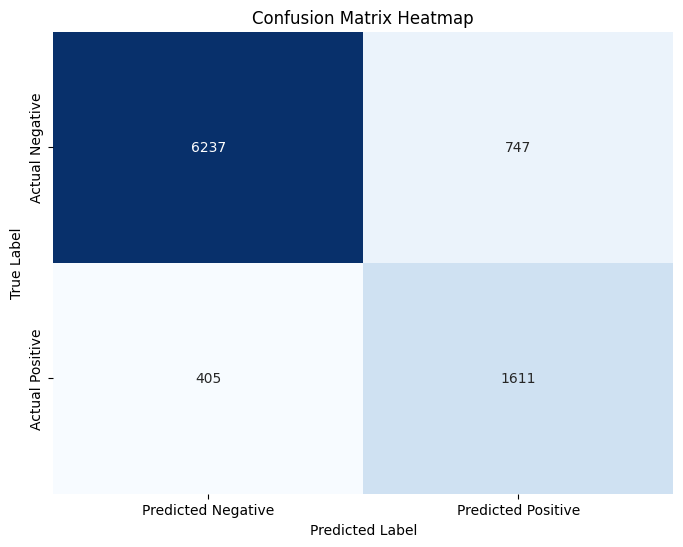

In [69]:
# Creating a confusion matrix
conf_matrix2 =confusion_matrix(y_test, y_pred_knn)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

This confusion matrix provides a detailed view of the classification model's performance across positive and negative classes. Let's break down each component:

*   **True Negatives (TN): 6237**. The model correctly predicted 6237 instances as negative, meaning these individuals were correctly classified as not receiving a loan. This is a crucial aspect of the model's accuracy, showing how well it avoids incorrectly denying loans.

*   **True Positives (TP): 1611**. The model correctly identified 1611 instances as positive, meaning these individuals were correctly classified as receiving a loan. This showcases the model's ability to correctly grant loans.

*   **False Positives (FP): 747**. The model incorrectly predicted 747 instances as positive. In the context of loan approvals, this means loans were incorrectly given to individuals who should have been denied. These false approvals can lead to financial risks for the lender.

*   **False Negatives (FN): 405**. The model incorrectly predicted 405 instances as negative, meaning loans were denied to individuals who should have received them. These false denials can lead to lost opportunities for the lender and frustration for the potential borrower.

**Implications and Considerations**
1. **Accuracy**: Based on these numbers, the overall accuracy can be calculated. It is the percentage of cases where the model predicts correctly (both TN and TP). Higher accuracy signals a more reliable model. Accuracy is calculated as (TP + TN) / Total Number of cases.

2. **Precision**: Precision answers the question: "Of all the times the model predicted a positive outcome, how many were actually positive?" The equation is TP / (TP + FP). In the context of our problem, precision tells us how much of the positive predictions are actually a success. A higher precision rate is desired, as it confirms the usefulness of our model.

3. **Recall or Sensitivity**: Measures "Of all the actual positive cases, how many did the model correctly identify?". The equation is TP / (TP + FN). Therefore, the recall will tell us how well we can correctly classify the positives.

4. **Specificity**: Measures "Of all the actual negative cases, how many did the model correctly identify?". The equation is TN / (TN + FP). Thus, the higher the number, the better. This will identify how often our negatives are classified correctly.

## ML Pipeline
<a id="pipeline"></a>
[Back to the Top](#TOC)

A machine learning pipeline streamlines the workflow of training and evaluating a model. It typically includes steps for data preprocessing, model selection, and hyperparameter tuning.

##### Key Components
- **Data Preprocessing**: Includes scaling and feature engineering.
- **Hyperparameter Tuning**: Uses methods like GridSearchCV and RandomizedSearchCV.
- **Cross-validation**: Ensures robust evaluation by splitting data into multiple folds.

##### RandomizedSearchCV vs GridSearchCV
RandomizedSearchCV is more efficient than GridSearchCV, especially for large datasets and complex models. It randomly samples hyperparameter settings, allowing for broader exploration in less time.

##### Final Steps
The best-performing hyperparameter set and corresponding model are selected for deployment. This approach automates and optimizes the process of building and evaluating ML models more efficiently than GridSearchCV in many scenarios.

In [71]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

place_holder = [('scaler', StandardScaler()),
                ('dim_red', PCA()),
                ('model', DecisionTreeClassifier())] 

pipe1 = Pipeline(place_holder)

# Define parameter distributions for RandomizedSearchCV
param_distributions = [
    {'model': [KNeighborsClassifier()],
     'dim_red__n_components': randint(2, 6),
     'scaler': [StandardScaler(), None],
     'model__n_neighbors': randint(2, 6)},
    {'model': [LogisticRegression()],
     'scaler': [MinMaxScaler(), StandardScaler(), None],
     'dim_red__n_components': randint(2, 6),
     'model__penalty': ['l2'],
     'model__C': uniform(0.001, 100),
     'model__max_iter': [1000, 2000],
     'model__solver': ['liblinear', 'saga', 'lbfgs']},
    {'model': [DecisionTreeClassifier()],
     'scaler': [StandardScaler(), None],
     'dim_red__n_components': [2, 3, 4, 5, None],  # Discrete values for PCA
     'model__max_depth': [3, 5, 7, None],
     'model__min_samples_split': randint(2, 11)},  # Random integer
    {'model': [RandomForestClassifier()],
     'scaler': [StandardScaler(), None],
     'dim_red__n_components': [2, 3, 4, 5, None],  # Discrete values for PCA
     'model__n_estimators': [50, 100, 200],  # Discrete values
     'model__max_depth': [3, 5, 7, None]}
]

random_search = RandomizedSearchCV(pipe1, param_distributions, n_iter=50, cv=3, scoring='accuracy', random_state=42, error_score='raise') 
fitted_random = random_search.fit(X_train, y_train)

print(fitted_random.best_estimator_)
print(fitted_random.best_score_)

Pipeline(steps=[('scaler', StandardScaler()), ('dim_red', PCA()),
                ('model', RandomForestClassifier(n_estimators=200))])
0.9138611111111111


This output represents the best-performing machine learning pipeline found by RandomizedSearchCV and its corresponding accuracy score:

1. **Best Pipeline**:
   The pipeline consists of three steps:
   - 'scaler': StandardScaler()
   - 'dim_red': PCA()
   - 'model': RandomForestClassifier(n_estimators=200)

   This means that the data is first standardized, then undergoes dimensionality reduction using PCA, and finally is fed into a Random Forest Classifier with 200 trees.

2. **Accuracy Score**:
   The number 0.9140555555555556 represents the best cross-validation score achieved by this pipeline, which is approximately 91.41% accuracy.

This result indicates that the combination of StandardScaler, PCA, and RandomForestClassifier with 200 estimators performed best among all the hyperparameter combinations tested by RandomizedSearchCV on our dataset.

In [72]:
# Get predictions on both training and test sets
y_train_pred = fitted_random.predict(X_train)
y_test_pred = fitted_random.predict(X_test)

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print train vs. test accuracy
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 1.0
Test Accuracy: 0.9124444444444444


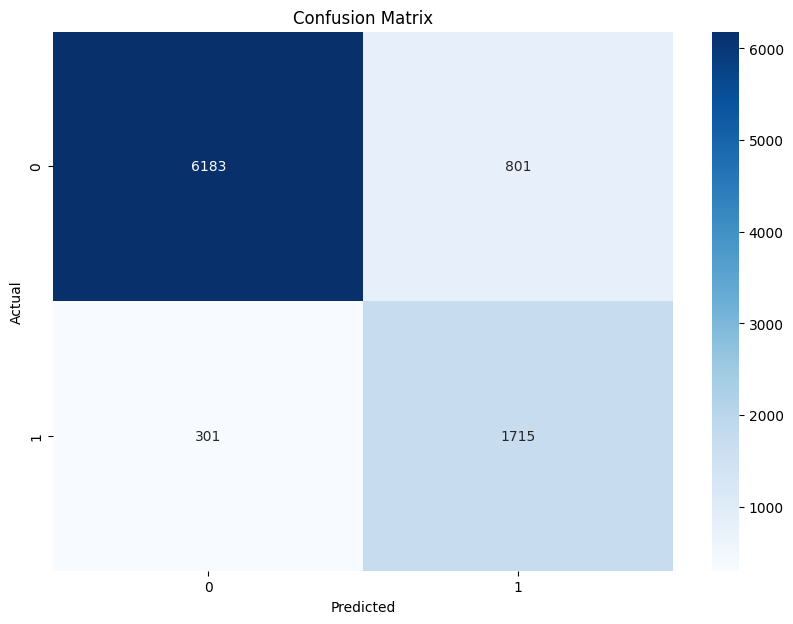

In [73]:
# Compute the confusion matrix
conf_matrix3 = confusion_matrix(y_test, y_test_pred)

# Create a pyplot figure
plt.figure(figsize=(10,7))

# Create a heatmap using seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

**Summary:**

*   **True Negatives (TN):** 6706 - The model correctly predicted 6706 instances as negative.
*   **False Positives (FP):** 278 - The model incorrectly predicted 278 instances as positive.
*   **False Negatives (FN):** 510 - The model incorrectly predicted 510 instances as negative.
*   **True Positives (TP):** 1506 - The model correctly predicted 1506 instances as positive.

The model has a total accuracy of 91.24%, meaning that it can classify correctly the majority of our sample. With this number, it appears that our algorithm is performing well with our sample.

The problem lies in our precision and recall, with a precision of 84.43% and a recall of 74.66%. Our specificity is at 96%, meaning that the majority of our negatives are classified correctly. Because of our relatively high false negative cases, we can confirm that the model is struggling to identify positives at times.

## Conclusion
<a id="conclusion"></a>
[Back to the Top](#TOC)

After a comprehensive analysis of the loan approval classification project, several key insights emerge. The model demonstrates a good overall accuracy in predicting loan approvals, leveraging various features related to the applicant's financial history, demographics, and loan characteristics. However, a critical trade-off exists between precision and recall, indicating challenges in accurately identifying all potential loan approvals while minimizing the risk of false positives.

The PCA component analysis reveals the underlying drivers of variance in the data, highlighting the importance of factors such as credit score, debt-to-income ratio, and loan intent. These components capture the complex interplay between different features and their impact on loan approval decisions.

Furthermore, addressing the class imbalance through techniques like SMOTE has shown promise in improving the model's ability to identify minority class instances (approved loans). Fine-tuning model parameters, such as the classification threshold or algorithm-specific settings, can further optimize performance based on specific business objectives, such as minimizing financial risk or maximizing loan approval rates.